# SBI Training Workflow with sbi_delta

This notebook demonstrates how to set up, train, and evaluate a simulation-based inference (SBI) model for multiplexed fluorescence microscopy using the new `SBITrainer` class and the sbi_delta configuration and manager system.

We will:
- Set up experiment configuration (fluorophores, filters, priors, training parameters)
- Initialize the SBITrainer
- Set up the prior distribution
- Generate training data
- Train the SBI model
- Evaluate on validation data
- Analyze multiplexing capacity
- Save experiment results


In [1]:
# Section 1: Import Required Libraries
import os, sys
base_path = os.path.abspath("../..")
sys.path.append(base_path)  # Adjust path as needed
import numpy as np
import torch
from sbi_delta.config import BaseConfig, ExcitationConfig, FilterConfig, PriorConfig
from sbi_delta.spectra_manager import SpectraManager
from sbi_delta.excitation_manager import ExcitationManager
from sbi_delta.filter_bank import FilterBank
from sbi_delta.prior_manager import PriorManager
from sbi_delta.simulator.emission_simulator import EmissionSimulator
from sbi_delta.trainer import Trainer


In [2]:
# Section 2: Define Experiment Configuration
# Define fluorophores, filters, and prior
fluorophore_names = ["JF479", "JF525", "JF552","JF608", "JFX650"]

base_cfg = BaseConfig(
    min_wavelength=450,
    max_wavelength=800,
    wavelength_step=1,
    spectra_folder=os.path.join(base_path, "data/spectra_npz"),
    dye_names=fluorophore_names,
    bg_dye='AF_v1',
    photon_budget=1000,
)
exc_cfg = ExcitationConfig(excitation_mode="min_crosstalk")
filter_cfgs = [
    FilterConfig(start, stop, sharpness=1)
    for start, stop in zip([480, 520, 560, 610,660], [520, 550, 600, 640,700])
]
prior_cfg = PriorConfig(
    dirichlet_concentration=5.0,
    include_background_ratio=True,
    background_ratio_bounds=(0.05, 0.15),

)

spectra_mgr = SpectraManager(base_cfg)
spectra_mgr.load()
excitation_mgr = ExcitationManager(base_cfg, exc_cfg, spectra_mgr)
filter_bank = FilterBank(base_cfg, filter_cfgs)
prior_mgr = PriorManager(prior_cfg, base_cfg)
simulator = EmissionSimulator(
    spectra_manager=spectra_mgr,
    filter_bank=filter_bank,
    config=base_cfg,
    excitation_manager=excitation_mgr,
    prior_manager=prior_mgr,
)
print(simulator.prior_manager)

PriorManager(n_fluorophores=5, dye_names=['JF479', 'JF525', 'JF552', 'JF608', 'JFX650'], bg_dye='AF_v1', dirichlet_concentration=5.0, include_background_ratio=True, background_ratio_bounds=(0.05, 0.15))


array([<Axes: title={'center': 'JF479'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JF525'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JF552'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JF608'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'JFX650'}, xlabel='Fraction', ylabel='Density'>,
       <Axes: title={'center': 'Background Ratio'}, xlabel='Ratio', ylabel='Density'>],
      dtype=object)

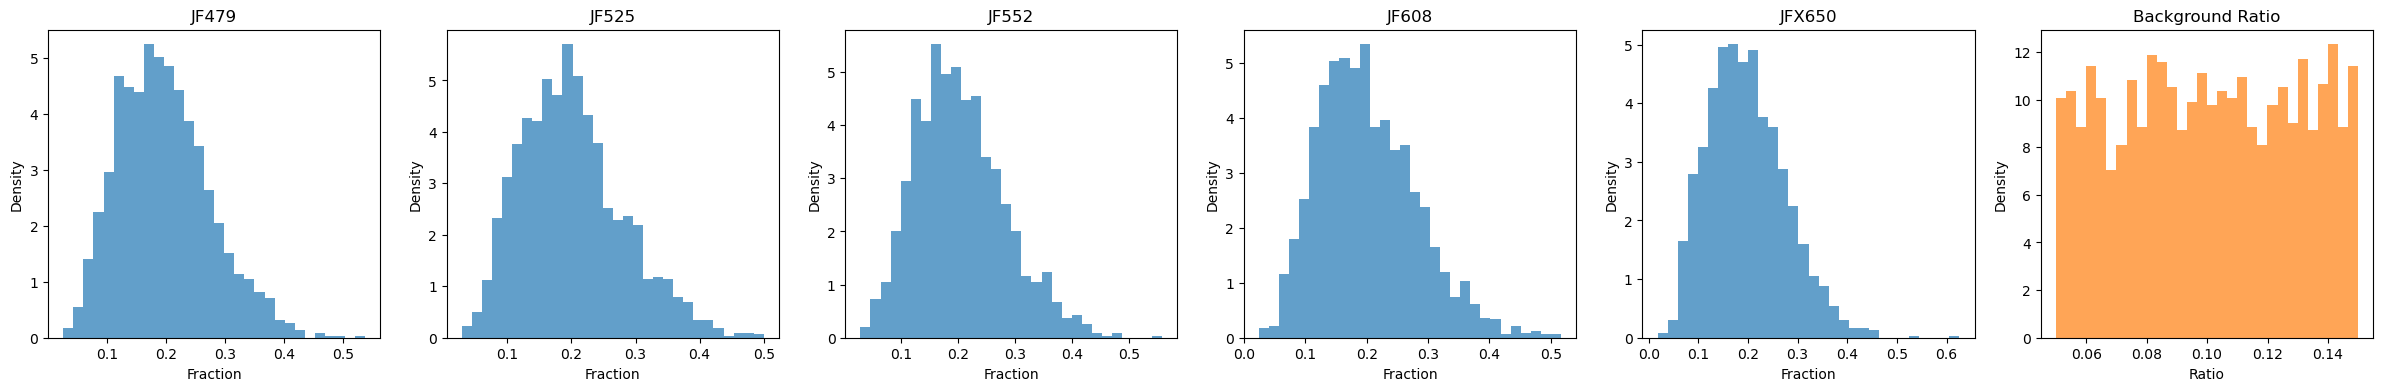

In [3]:
prior_mgr.visualize_joint_prior(2000)

In [4]:
excitation_mgr.excitation_wavelengths

array([477, 524, 554, 606, 650])

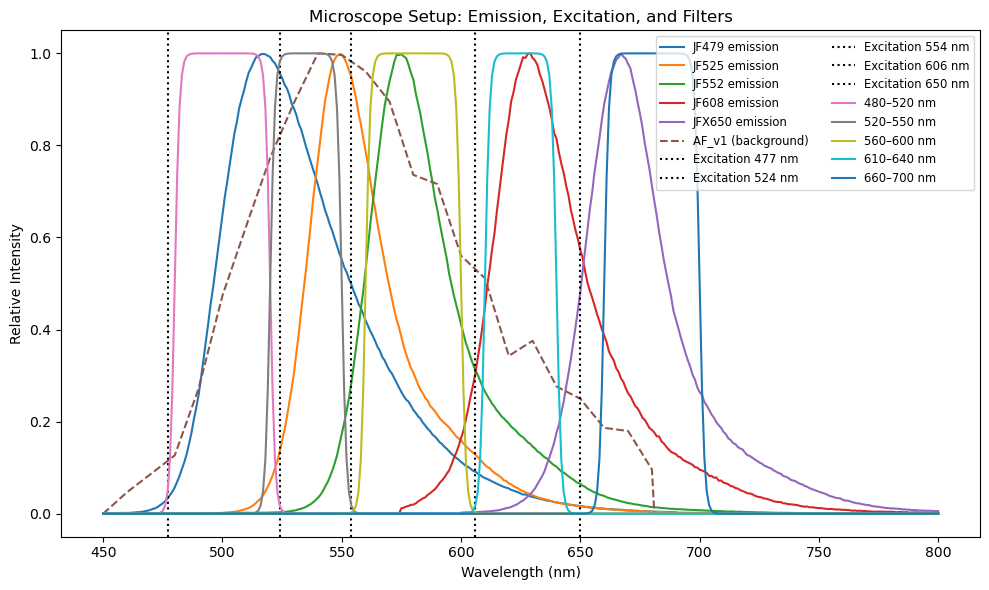

In [5]:
import matplotlib.pyplot as plt

# Plot emission spectra for all dyes and background
wavelengths = simulator.spectra_manager.wavelength_grid
plt.figure(figsize=(10, 6))

# Plot dye emission spectra
for dye in simulator.config.dye_names:
    em = simulator.spectra_manager.get_emission(dye)
    plt.plot(wavelengths, em, label=f"{dye} emission")

# Plot background emission if present
if hasattr(simulator.config, 'bg_dye') and simulator.config.bg_dye:
    bg_em = simulator.spectra_manager.get_emission(simulator.config.bg_dye)
    plt.plot(wavelengths, bg_em, label=f"{simulator.config.bg_dye} (background)", linestyle='--')

# Plot excitation lines
for exc in simulator.excitation_manager.excitation_wavelengths:
    plt.axvline(exc, color='k', linestyle=':', label=f"Excitation {exc} nm")
ax = plt.gca()
# Plot filter regions
simulator.filter_bank.plot_all_filters(ax=ax)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Intensity")
plt.title("Microscope Setup: Emission, Excitation, and Filters")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

In [6]:
# Section 3: Initialize Trainer with Simulator
trainer = Trainer(simulator, n_train=10000, n_val=2000, save_dir="sbi_training_demo_results")
print("Trainer prior:", trainer.prior)
posterior = trainer.train()
print("Posterior trained.")

Trainer prior: JointPrior()
 Neural network successfully converged after 216 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 216
        Best validation performance: -19.6940
        -------------------------
        
Posterior trained.


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(


In [7]:
# Section 7: Evaluate Model on Validation Data
r2_scores, rmse_scores, rmse= trainer.validate()
print(f"Validation mean R^2: {np.mean(r2_scores):.3f}, RMSE: {rmse:.4f}")


Validating: 100%|██████████| 2000/2000 [00:42<00:00, 46.69it/s]


Validation mean R^2: 0.943, RMSE: 0.0167
Validation mean R^2: 0.943, RMSE: 0.0167


## Visualize Prediction Quality and Error Distributions
Explore model performance using the new plotting utilities in the Trainer class.

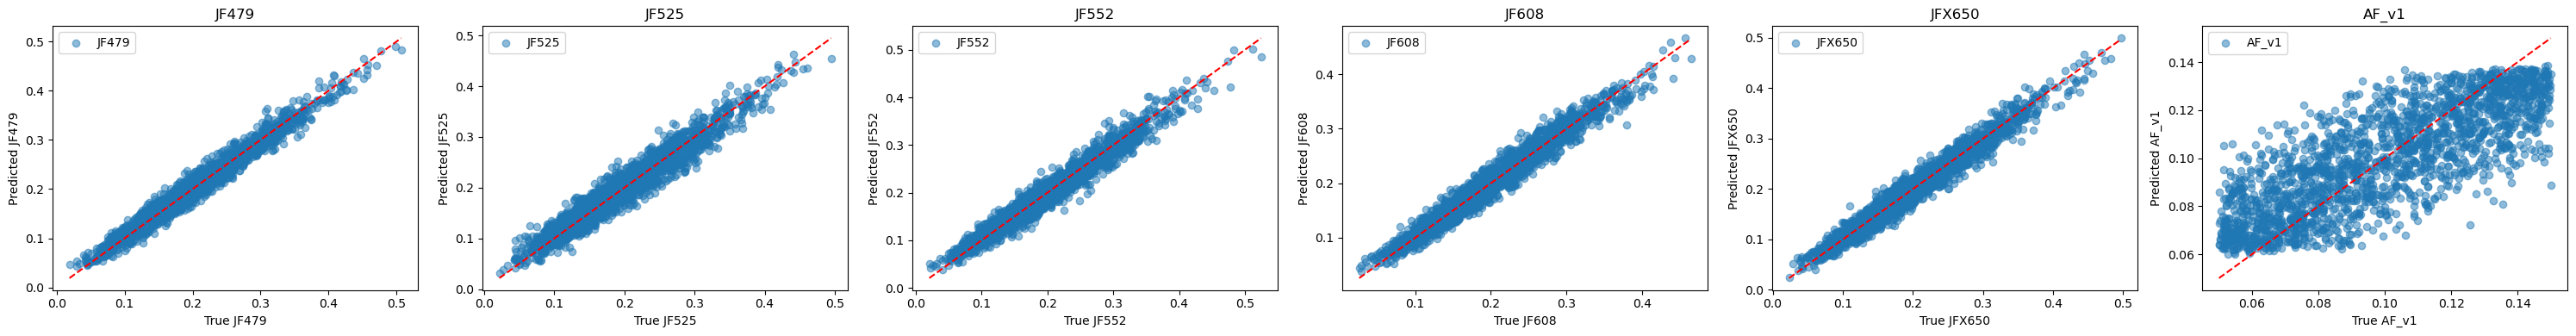

In [8]:
# Scatter plot: predicted vs true parameters for all validation examples
trainer.plot_pred_vs_true();

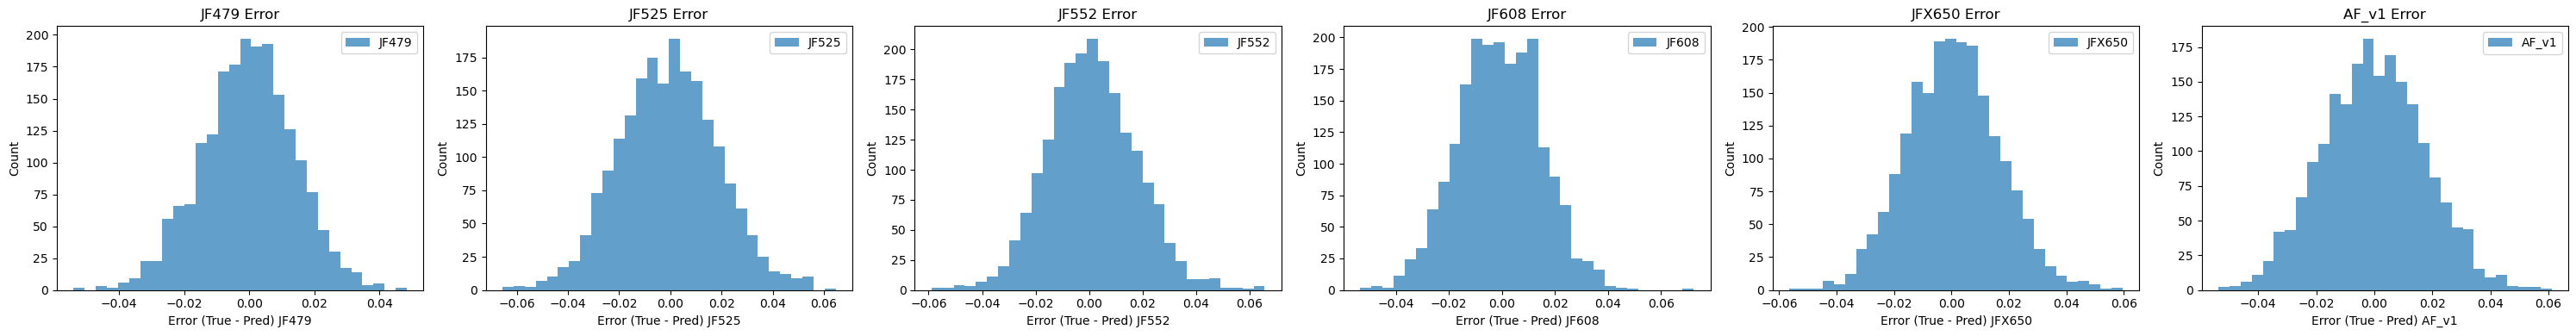

In [9]:
# Histograms of errors (true - predicted) for each parameter
trainer.plot_error_histograms();

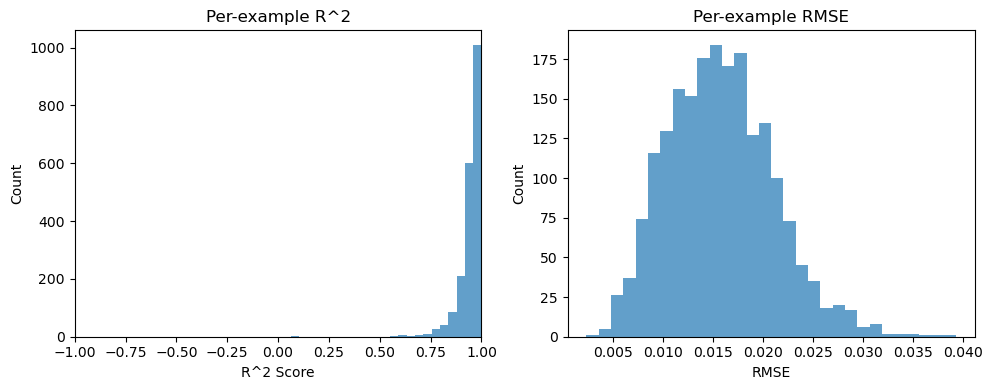

In [10]:
# Histograms of per-example R² and RMSE scores
trainer.plot_r2_rmse_distributions();

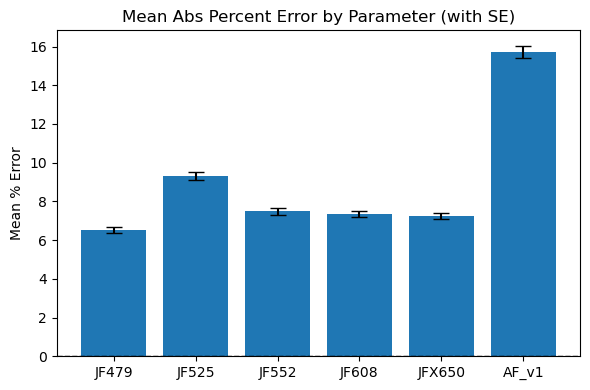

In [11]:
# Bar plot: mean percent error for each dye/background parameter with error bars (std)
import numpy as np
import matplotlib.pyplot as plt

val_theta = trainer.results['val_theta'].numpy()
pred_theta = trainer.results['pred_theta']

# Avoid division by zero: add small epsilon
epsilon = 1e-8
percent_errors = np.abs((pred_theta - val_theta) / (val_theta + epsilon) * 100)
mean_percent_error = np.mean(percent_errors, axis=0)
std_percent_error = np.std(percent_errors, axis=0)/ np.sqrt(percent_errors.shape[0])  # Standard error of the mean

# Get dye/background names
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
if len(names) < mean_percent_error.shape[0]:
    names += [f'Param {i+1}' for i in range(len(names), mean_percent_error.shape[0])]

plt.figure(figsize=(6, 4))
plt.bar(names, mean_percent_error, yerr=std_percent_error, capsize=6)
plt.ylabel('Mean % Error')
plt.title('Mean Abs Percent Error by Parameter (with SE)')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


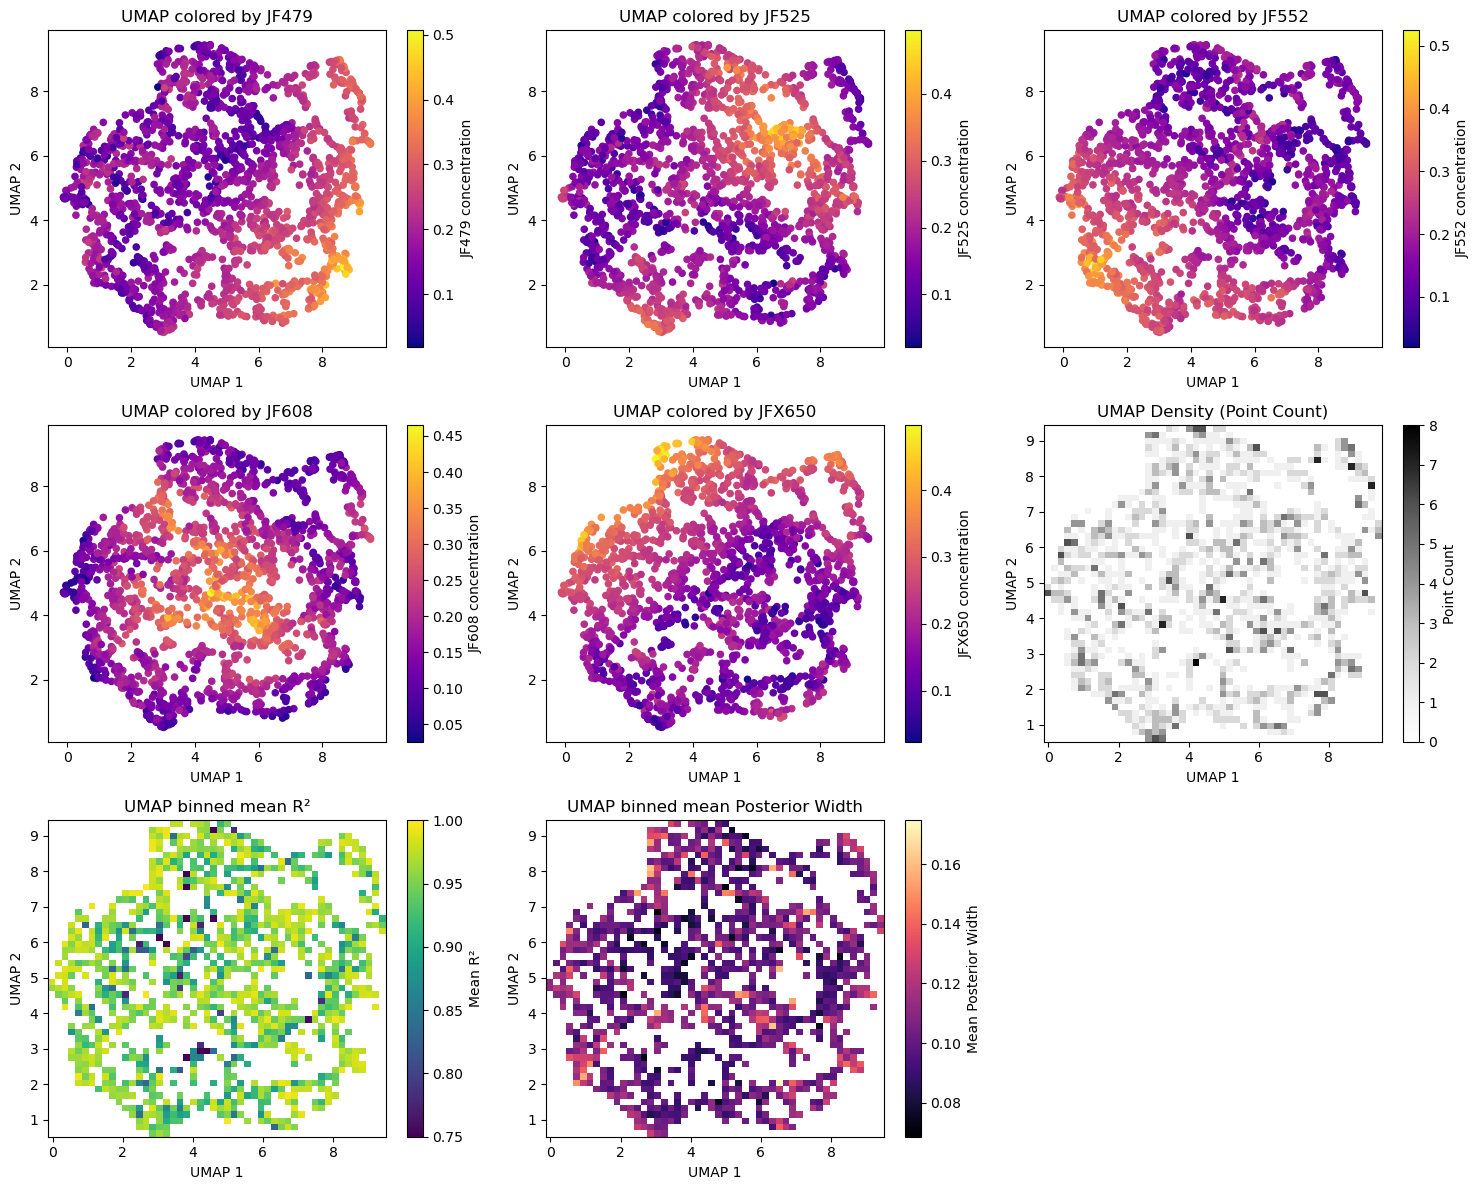

In [12]:
# UMAP subplots: color by each dye concentration, and binned mean for density, mean R², and mean posterior width
import numpy as np
import matplotlib.pyplot as plt
try:
    from umap import UMAP
except ImportError:
    from umap import umap_ as UMAP  # fallback if needed

n_dyes = len(trainer.simulator.config.dye_names)
names = list(trainer.simulator.config.dye_names)
concs = val_theta[:, :n_dyes]
proj = UMAP(n_components=2, random_state=0).fit_transform(concs)

ncols = 3
nrows = int(np.ceil((n_dyes + 3) / ncols))  # +3 for density, mean R², mean width
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

# Plot each dye concentration
for i, dye in enumerate(names):
    sc = axes[i].scatter(proj[:, 0], proj[:, 1], c=concs[:, i], cmap='plasma', s=20)
    cbar = plt.colorbar(sc, ax=axes[i])
    cbar.set_label(f'{dye} concentration')
    axes[i].set_title(f'UMAP colored by {dye}')
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')

# Define bins for 2D histograms
bins = 50
xedges = np.linspace(proj[:, 0].min(), proj[:, 0].max(), bins+1)
yedges = np.linspace(proj[:, 1].min(), proj[:, 1].max(), bins+1)
X, Y = np.meshgrid(0.5*(xedges[:-1]+xedges[1:]), 0.5*(yedges[:-1]+yedges[1:]))

# Density (point count) map using 2D histogram
hist, _, _ = np.histogram2d(proj[:, 0], proj[:, 1], bins=[xedges, yedges])
ax_density = axes[n_dyes]
pcm = ax_density.pcolormesh(X, Y, hist.T, cmap='Greys')
cbar = plt.colorbar(pcm, ax=ax_density)
cbar.set_label('Point Count')
ax_density.set_title('UMAP Density (Point Count)')
ax_density.set_xlabel('UMAP 1')
ax_density.set_ylabel('UMAP 2')

# Binned mean R² per bin
if 'r2_scores' in trainer.results:
    r2_scores = np.array(trainer.results['r2_scores'])
    mean_r2 = np.full((bins, bins), np.nan)
    for i in range(bins):
        for j in range(bins):
            mask = (proj[:, 0] >= xedges[i]) & (proj[:, 0] < xedges[i+1]) & (proj[:, 1] >= yedges[j]) & (proj[:, 1] < yedges[j+1])
            if np.any(mask):
                mean_r2[i, j] = np.mean(r2_scores[mask])
    ax_r2 = axes[n_dyes+1]
    im_r2 = ax_r2.pcolormesh(X, Y, mean_r2.T, cmap='viridis', shading='auto')
    cbar = plt.colorbar(im_r2, ax=ax_r2)
    cbar.set_label('Mean R²')
    ax_r2.set_title('UMAP binned mean R²')
    ax_r2.set_xlabel('UMAP 1')
    ax_r2.set_ylabel('UMAP 2')
    im_r2.set_clim([0.75, 1])  # Set color limits for R²

# Binned mean posterior width per bin
if 'posterior_width' in trainer.results:
    posterior_width = trainer.results['posterior_width']
    mean_width = posterior_width.mean(axis=1)
    mean_width_bin = np.full((bins, bins), np.nan)
    for i in range(bins):
        for j in range(bins):
            mask = (proj[:, 0] >= xedges[i]) & (proj[:, 0] < xedges[i+1]) & (proj[:, 1] >= yedges[j]) & (proj[:, 1] < yedges[j+1])
            if np.any(mask):
                mean_width_bin[i, j] = np.mean(mean_width[mask])
    ax_width = axes[n_dyes+2]
    im_width = ax_width.pcolormesh(X, Y, mean_width_bin.T, cmap='magma', shading='auto')
    cbar = plt.colorbar(im_width, ax=ax_width)
    cbar.set_label('Mean Posterior Width')
    ax_width.set_title('UMAP binned mean Posterior Width')
    ax_width.set_xlabel('UMAP 1')
    ax_width.set_ylabel('UMAP 2')

# Hide unused subplots
for j in range(n_dyes+3, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

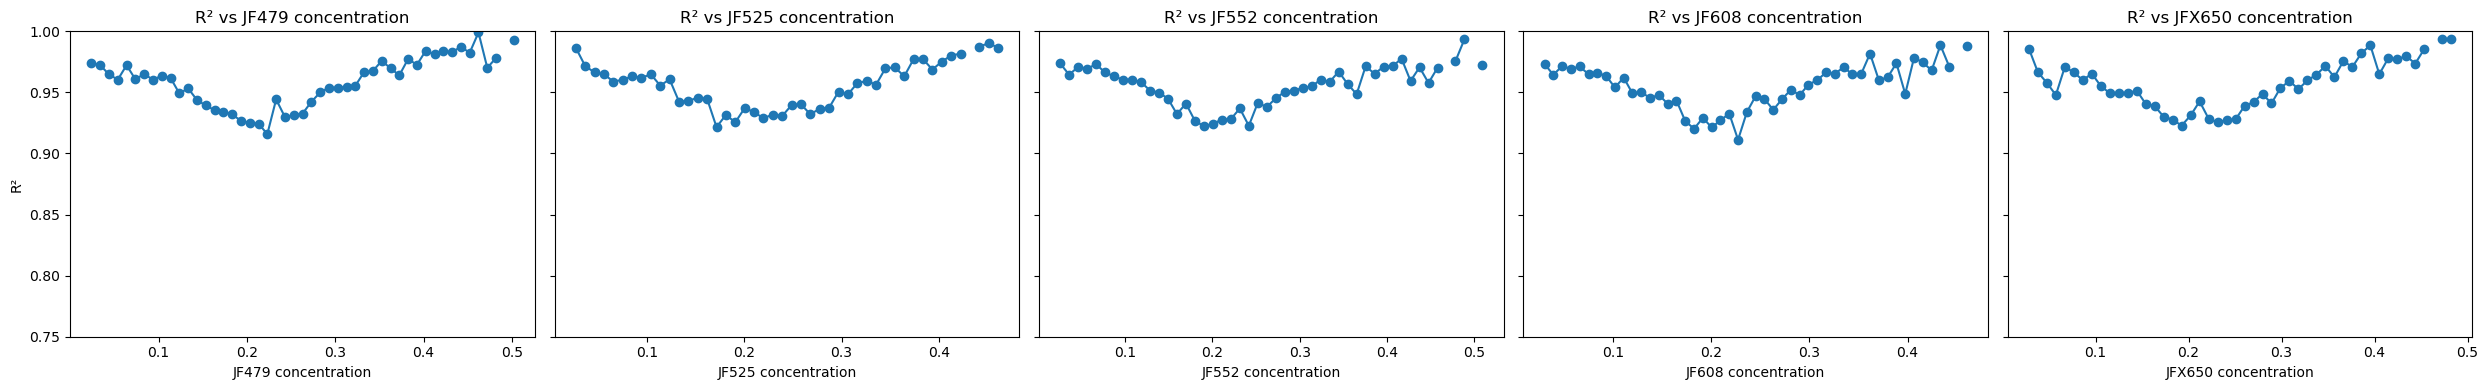

In [13]:
# Plot R² as a function of concentration for each dye
import numpy as np
import matplotlib.pyplot as plt

n_dyes = len(trainer.simulator.config.dye_names)
names = list(trainer.simulator.config.dye_names)
concs = val_theta[:, :n_dyes]
r2_scores = np.array(trainer.results['r2_scores'])

fig, axes = plt.subplots(1, n_dyes, figsize=(5*n_dyes, 4), sharey=True)
if n_dyes == 1:
    axes = [axes]

for i, dye in enumerate(names):
    # Bin concentrations for smoother curves
    bins = np.linspace(concs[:, i].min(), concs[:, i].max(), 50)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    inds = np.digitize(concs[:, i], bins) - 1
    mean_r2 = [np.mean(r2_scores[inds == j]) if np.any(inds == j) else np.nan for j in range(len(bin_centers))]
    axes[i].plot(bin_centers, mean_r2, marker='o')
    axes[i].set_xlabel(f'{dye} concentration')
    axes[i].set_title(f'R² vs {dye} concentration')
    axes[i].set_ylim(.75, 1)
axes[0].set_ylabel('R²')
plt.tight_layout()
plt.show()

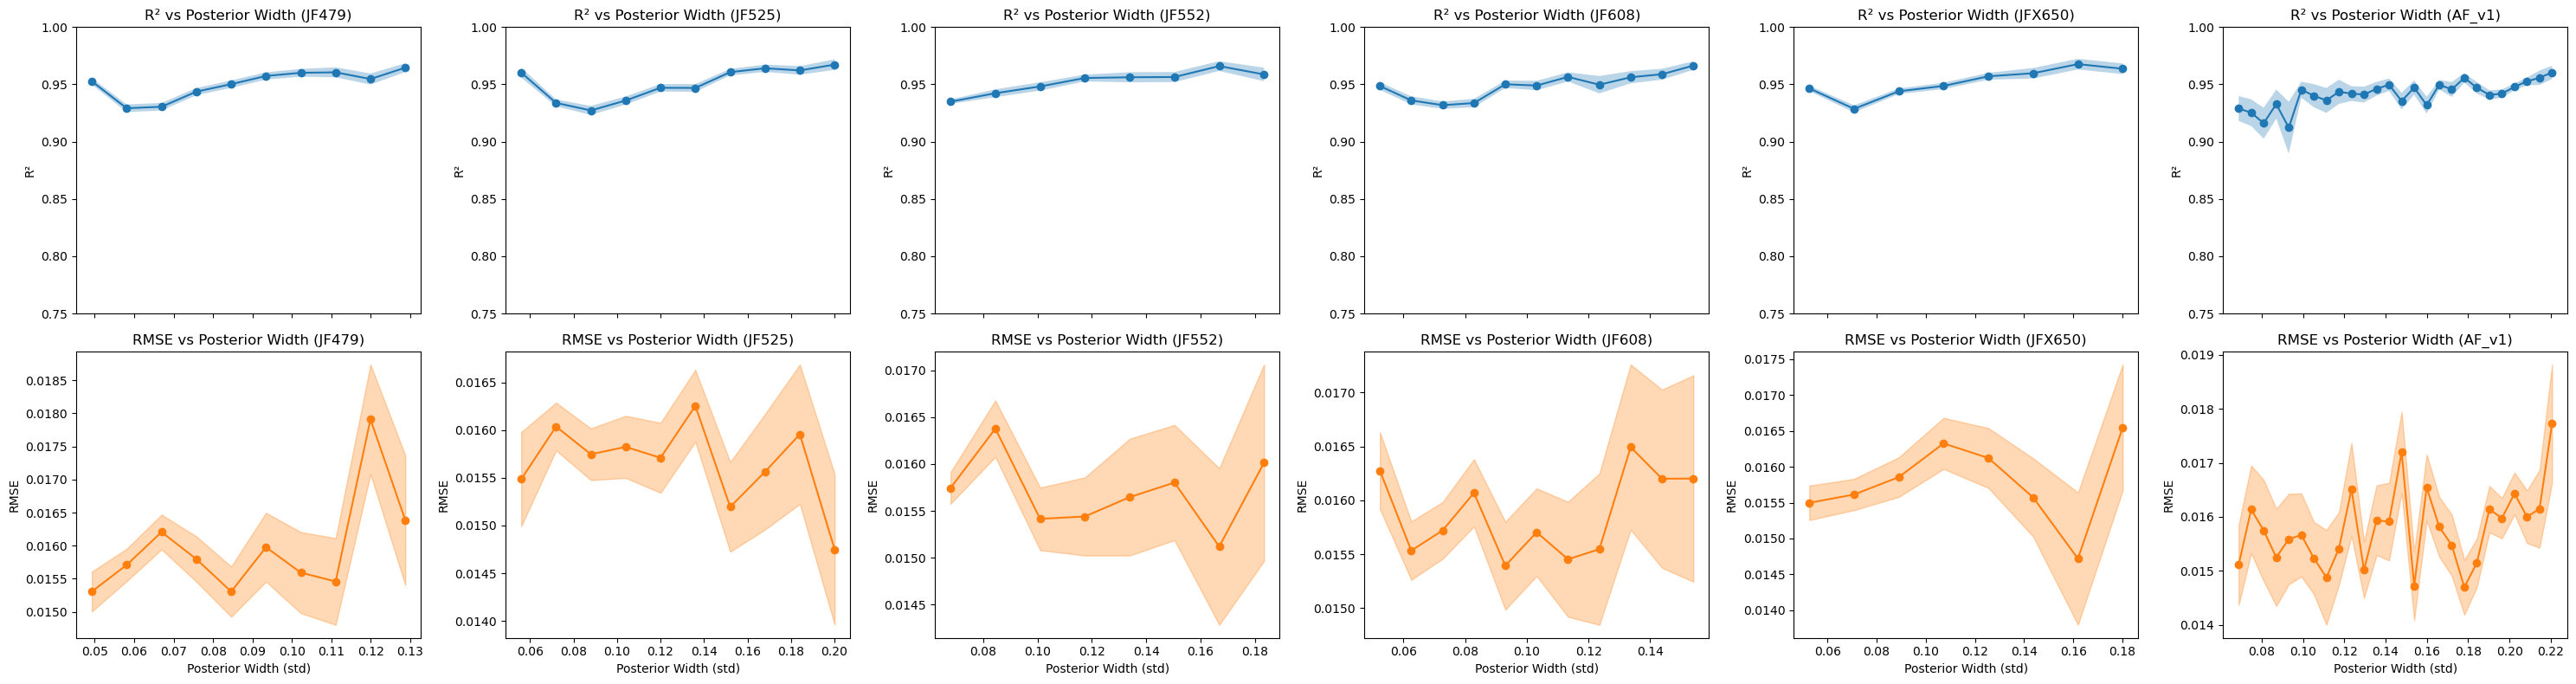

In [14]:
# Plot R² and RMSE as a function of posterior width for each parameter, with SEM shading and min count filter
import numpy as np
import matplotlib.pyplot as plt

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
r2_scores = np.array(trainer.results['r2_scores'])
rmse_scores = np.array(trainer.results['rmse_scores'])
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
n_params = posterior_width.shape[1]
if len(names) < n_params:
    names += [f'Param {i+1}' for i in range(len(names), n_params)]

fig, axes = plt.subplots(2, n_params, figsize=(5*n_params, 8), sharex='col')
if n_params == 1:
    axes = np.array([[axes[0]], [axes[1]]])

min_count = 30  # Minimum number of samples per bin

for i in range(n_params):
    # Bin posterior width for smoother curves
    bins = np.linspace(posterior_width[:, i].min(), posterior_width[:, i].max(), 30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    inds = np.digitize(posterior_width[:, i], bins) - 1
    mean_r2, sem_r2, mean_rmse, sem_rmse = [], [], [], []
    for j in range(len(bin_centers)):
        mask = inds == j
        count = np.sum(mask)
        if count >= min_count:
            mean_r2.append(np.mean(r2_scores[mask]))
            sem_r2.append(np.std(r2_scores[mask]) / np.sqrt(count))
            mean_rmse.append(np.mean(rmse_scores[mask]))
            sem_rmse.append(np.std(rmse_scores[mask]) / np.sqrt(count))
        else:
            mean_r2.append(np.nan)
            sem_r2.append(np.nan)
            mean_rmse.append(np.nan)
            sem_rmse.append(np.nan)
    mean_r2 = np.array(mean_r2)
    sem_r2 = np.array(sem_r2)
    mean_rmse = np.array(mean_rmse)
    sem_rmse = np.array(sem_rmse)
    # R² plot with SEM shading
    axes[0, i].plot(bin_centers, mean_r2, marker='o', label='Mean R²')
    axes[0, i].fill_between(bin_centers, mean_r2 - sem_r2, mean_r2 + sem_r2, alpha=0.3, label='SEM')
    axes[0, i].set_title(f'R² vs Posterior Width ({names[i]})')
    axes[0, i].set_ylabel('R²')
    axes[0, i].set_ylim(.75, 1)
    # RMSE plot with SEM shading
    axes[1, i].plot(bin_centers, mean_rmse, marker='o', color='C1', label='Mean RMSE')
    axes[1, i].fill_between(bin_centers, mean_rmse - sem_rmse, mean_rmse + sem_rmse, color='C1', alpha=0.3, label='SEM')
    axes[1, i].set_title(f'RMSE vs Posterior Width ({names[i]})')
    axes[1, i].set_xlabel('Posterior Width (std)')
    axes[1, i].set_ylabel('RMSE')
plt.tight_layout()
plt.show()

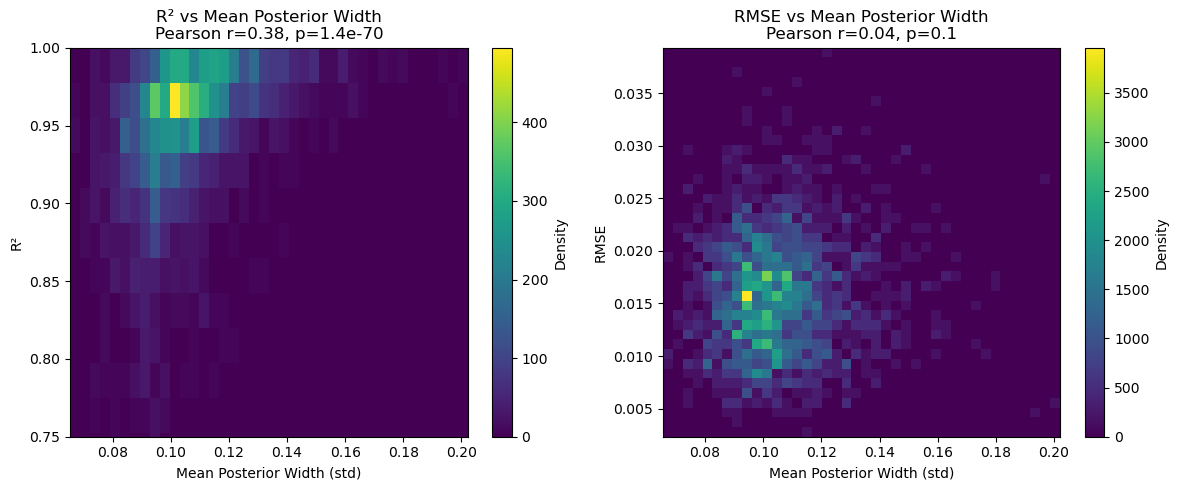

In [18]:
# Correlation between mean posterior width and R²/RMSE across all samples (2D density histograms)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
r2_scores = np.array(trainer.results['r2_scores'])
rmse_scores = np.array(trainer.results['rmse_scores'])

mean_width = posterior_width.mean(axis=1)

# Compute Pearson correlation
corr_r2, pval_r2 = pearsonr(mean_width, r2_scores)
corr_rmse, pval_rmse = pearsonr(mean_width, rmse_scores)

plt.figure(figsize=(12, 5))

# 2D histogram for R²
plt.subplot(1, 2, 1)
h1 = plt.hist2d(mean_width, r2_scores, bins=40, cmap='viridis', density=True)
plt.colorbar(h1[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('R²')
plt.title(f'R² vs Mean Posterior Width\nPearson r={corr_r2:.2f}, p={pval_r2:.2g}')
# Improved ylim: fit to data with margin
r2_min, r2_max = np.nanmin(r2_scores), np.nanmax(r2_scores)
r2_margin = 0.05 * (r2_max - r2_min)
plt.ylim(0.75,1)

# 2D histogram for RMSE
plt.subplot(1, 2, 2)
h2 = plt.hist2d(mean_width, rmse_scores, bins=40, cmap='viridis', density=True)
plt.colorbar(h2[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('RMSE')
plt.title(f'RMSE vs Mean Posterior Width\nPearson r={corr_rmse:.2f}, p={pval_rmse:.2g}')
plt.tight_layout()
plt.show()

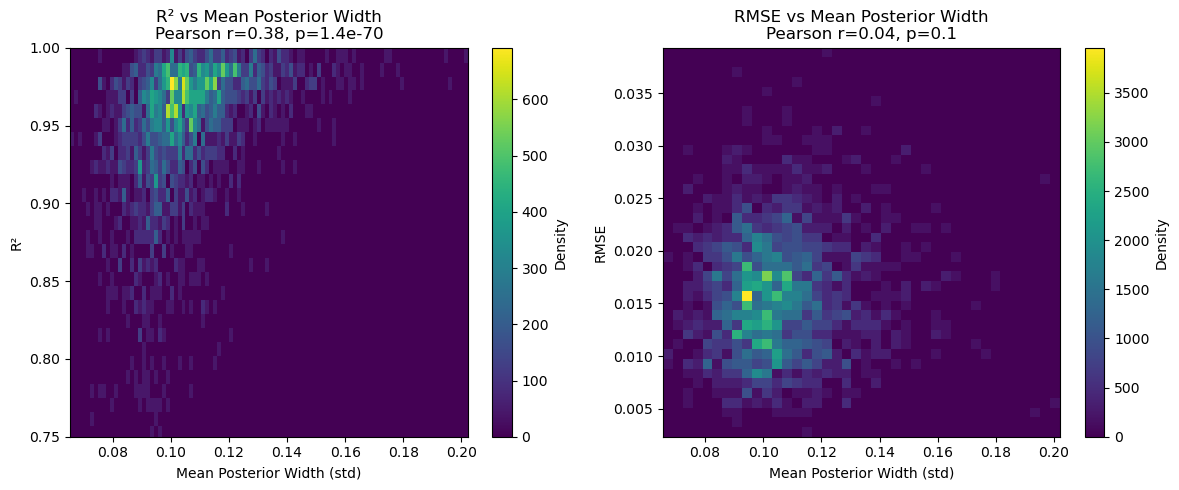

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
r2_scores = np.array(trainer.results['r2_scores'])
rmse_scores = np.array(trainer.results['rmse_scores'])

mean_width = posterior_width.mean(axis=1)

# Compute Pearson correlation
corr_r2, pval_r2 = pearsonr(mean_width, r2_scores)
corr_rmse, pval_rmse = pearsonr(mean_width, rmse_scores)

plt.figure(figsize=(12, 5))

# 2D histogram for R²
plt.subplot(1, 2, 1)
h1 = plt.hist2d(mean_width, r2_scores, bins=100, cmap='viridis', density=True)
plt.colorbar(h1[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('R²')
plt.title(f'R² vs Mean Posterior Width\nPearson r={corr_r2:.2f}, p={pval_r2:.2g}')
# Improved ylim: fit to data with margin
r2_min, r2_max = np.nanmin(r2_scores), np.nanmax(r2_scores)
r2_margin = 0.05 * (r2_max - r2_min)
plt.ylim(0.75, 1)

# 2D histogram for RMSE
plt.subplot(1, 2, 2)
h2 = plt.hist2d(mean_width, rmse_scores, bins=40, cmap='viridis', density=True)
plt.colorbar(h2[3], label='Density')
plt.xlabel('Mean Posterior Width (std)')
plt.ylabel('RMSE')
plt.title(f'RMSE vs Mean Posterior Width\nPearson r={corr_rmse:.2f}, p={pval_rmse:.2g}')
plt.tight_layout()
plt.show()

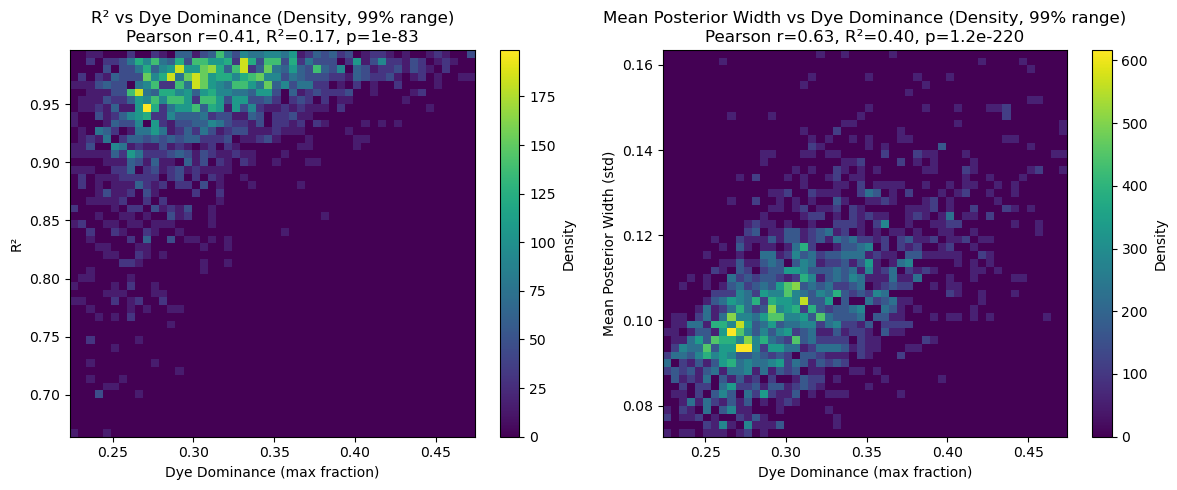

In [20]:
# Plot: Dye dominance (max fraction) vs R² and vs mean posterior width as 2D density plots with bins covering 99% of the data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate dye dominance (max fraction of any dye in each sample)
n_dyes = len(trainer.simulator.config.dye_names)
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']
dye_fractions = val_theta[:, :n_dyes] / np.clip(val_theta[:, :n_dyes].sum(axis=1, keepdims=True), 1e-8, None)
dominance = dye_fractions.max(axis=1)

# Get R² and mean posterior width
r2_scores = np.array(trainer.results['r2_scores'])
posterior_width = trainer.results['posterior_width']
mean_width = posterior_width.mean(axis=1)

# Compute 0.5th and 99.5th percentiles for all axes
x_min, x_max = np.percentile(dominance, [0.5, 99.5])
y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
y2_min, y2_max = np.percentile(mean_width, [0.5, 99.5])

# Compute correlations
corr_r2, pval_r2 = pearsonr(dominance, r2_scores)
r2_r2 = corr_r2 ** 2
corr_width, pval_width = pearsonr(dominance, mean_width)
r2_width = corr_width ** 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dominance vs R² (density, 99% range)
h1 = axes[0].hist2d(dominance, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
plt.colorbar(h1[3], ax=axes[0], label='Density')
axes[0].set_xlabel('Dye Dominance (max fraction)')
axes[0].set_ylabel('R²')
axes[0].set_title(f'R² vs Dye Dominance (Density, 99% range)\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
axes[0].set_ylim(y1_min, y1_max)

# Dominance vs mean posterior width (density, 99% range)
h2 = axes[1].hist2d(dominance, mean_width, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
plt.colorbar(h2[3], ax=axes[1], label='Density')
axes[1].set_xlabel('Dye Dominance (max fraction)')
axes[1].set_ylabel('Mean Posterior Width (std)')
axes[1].set_title(f'Mean Posterior Width vs Dye Dominance (Density, 99% range)\nPearson r={corr_width:.2f}, R²={r2_width:.2f}, p={pval_width:.2g}')
axes[1].set_ylim(y2_min, y2_max)

plt.tight_layout()
plt.show()

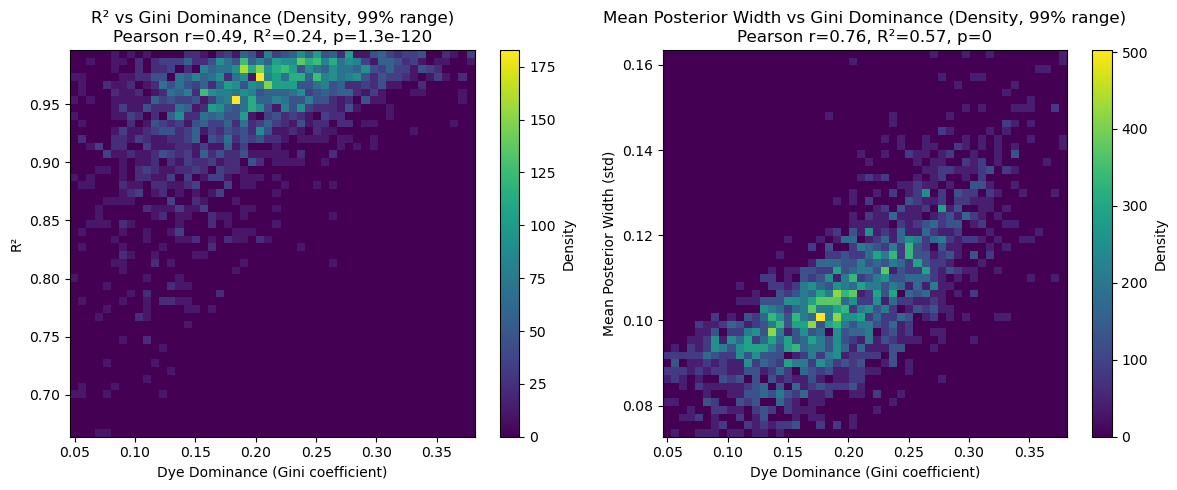

In [21]:
# Alternative dye dominance measure: Gini coefficient
def gini_coefficient(fractions):
    # fractions: shape (n_samples, n_dyes)
    sorted_fractions = np.sort(fractions, axis=1)
    n = fractions.shape[1]
    index = np.arange(1, n + 1)
    # Gini formula for each row
    gini = (np.sum((2 * index - n - 1) * sorted_fractions, axis=1)) / (n * np.sum(sorted_fractions, axis=1))
    return gini

gini_dominance = gini_coefficient(dye_fractions)

# Compute 0.5th and 99.5th percentiles for all axes
x_min, x_max = np.percentile(gini_dominance, [0.5, 99.5])
y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
y2_min, y2_max = np.percentile(mean_width, [0.5, 99.5])

# Compute correlations
corr_r2, pval_r2 = pearsonr(gini_dominance, r2_scores)
r2_r2 = corr_r2 ** 2
corr_width, pval_width = pearsonr(gini_dominance, mean_width)
r2_width = corr_width ** 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gini dominance vs R² (density, 99% range)
h1 = axes[0].hist2d(gini_dominance, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
plt.colorbar(h1[3], ax=axes[0], label='Density')
axes[0].set_xlabel('Dye Dominance (Gini coefficient)')
axes[0].set_ylabel('R²')
axes[0].set_title(f'R² vs Gini Dominance (Density, 99% range)\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
axes[0].set_ylim(y1_min, y1_max)

# Gini dominance vs mean posterior width (density, 99% range)
h2 = axes[1].hist2d(gini_dominance, mean_width, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
plt.colorbar(h2[3], ax=axes[1], label='Density')
axes[1].set_xlabel('Dye Dominance (Gini coefficient)')
axes[1].set_ylabel('Mean Posterior Width (std)')
axes[1].set_title(f'Mean Posterior Width vs Gini Dominance (Density, 99% range)\nPearson r={corr_width:.2f}, R²={r2_width:.2f}, p={pval_width:.2g}')
axes[1].set_ylim(y2_min, y2_max)

plt.tight_layout()
plt.show()

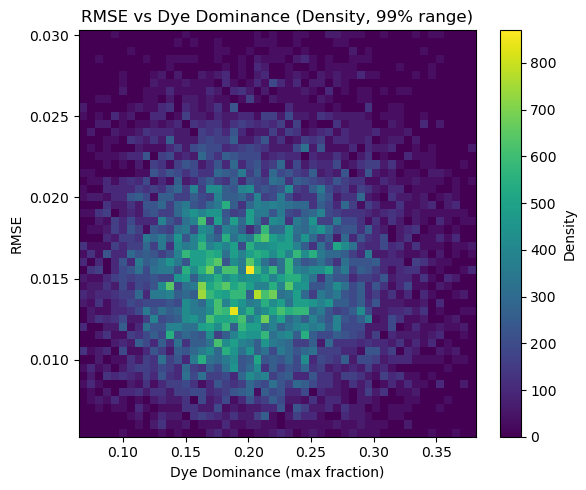

In [19]:
# Dye dominance vs RMSE (density) with bins covering 99% of the data
import numpy as np
# Compute 0.5th and 99.5th percentiles for both axes
x_min, x_max = np.percentile(gini_dominance, [0.5, 99.5])
y_min, y_max = np.percentile(rmse_scores, [0.5, 99.5])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
h3 = ax.hist2d(gini_dominance, rmse_scores, bins=[50, 50], range=[[x_min, x_max], [y_min, y_max]], cmap='viridis', density=True)
plt.colorbar(h3[3], ax=ax, label='Density')
ax.set_xlabel('Dye Dominance (max fraction)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Dye Dominance (Density, 99% range)')
plt.tight_layout()
plt.show()

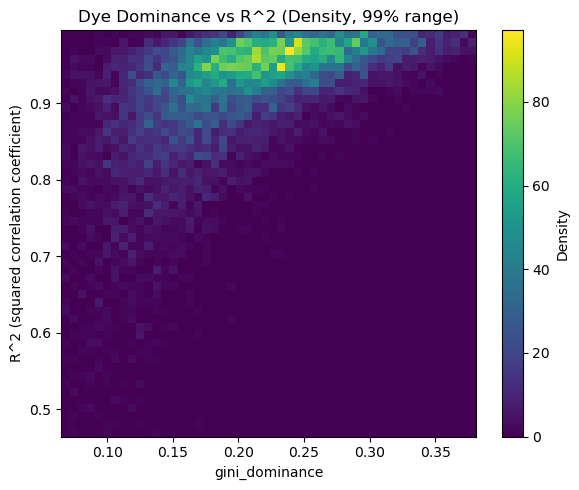

In [20]:
# Dye dominance vs RMSE (density) with bins covering 99% of the data
import numpy as np
# Compute 0.5th and 99.5th percentiles for both axes
x_min, x_max = np.percentile(gini_dominance, [0.5, 99.5])
y_min, y_max = np.percentile(r2_scores, [0.5, 99.5])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
h3 = ax.hist2d(gini_dominance,r2_scores, bins=[50, 50], range=[[x_min, x_max], [y_min, y_max]], cmap='viridis', density=True)
plt.colorbar(h3[3], ax=ax, label='Density')
ax.set_xlabel('gini_dominance')
ax.set_ylabel('R^2 (squared correlation coefficient)')
ax.set_title('Dye Dominance vs R^2 (Density, 99% range)')
plt.tight_layout()
plt.show()

In [21]:
# Calculate Pearson R^2 (squared correlation) between dye dominance and RMSE
from scipy.stats import pearsonr
corr, pval = pearsonr(gini_dominance,r2_scores)
r2 = corr**2
print(f"Pearson r: {corr:.3f}, R^2: {r2:.3f}, p-value: {pval:.2g}")

Pearson r: 0.522, R^2: 0.272, p-value: 0


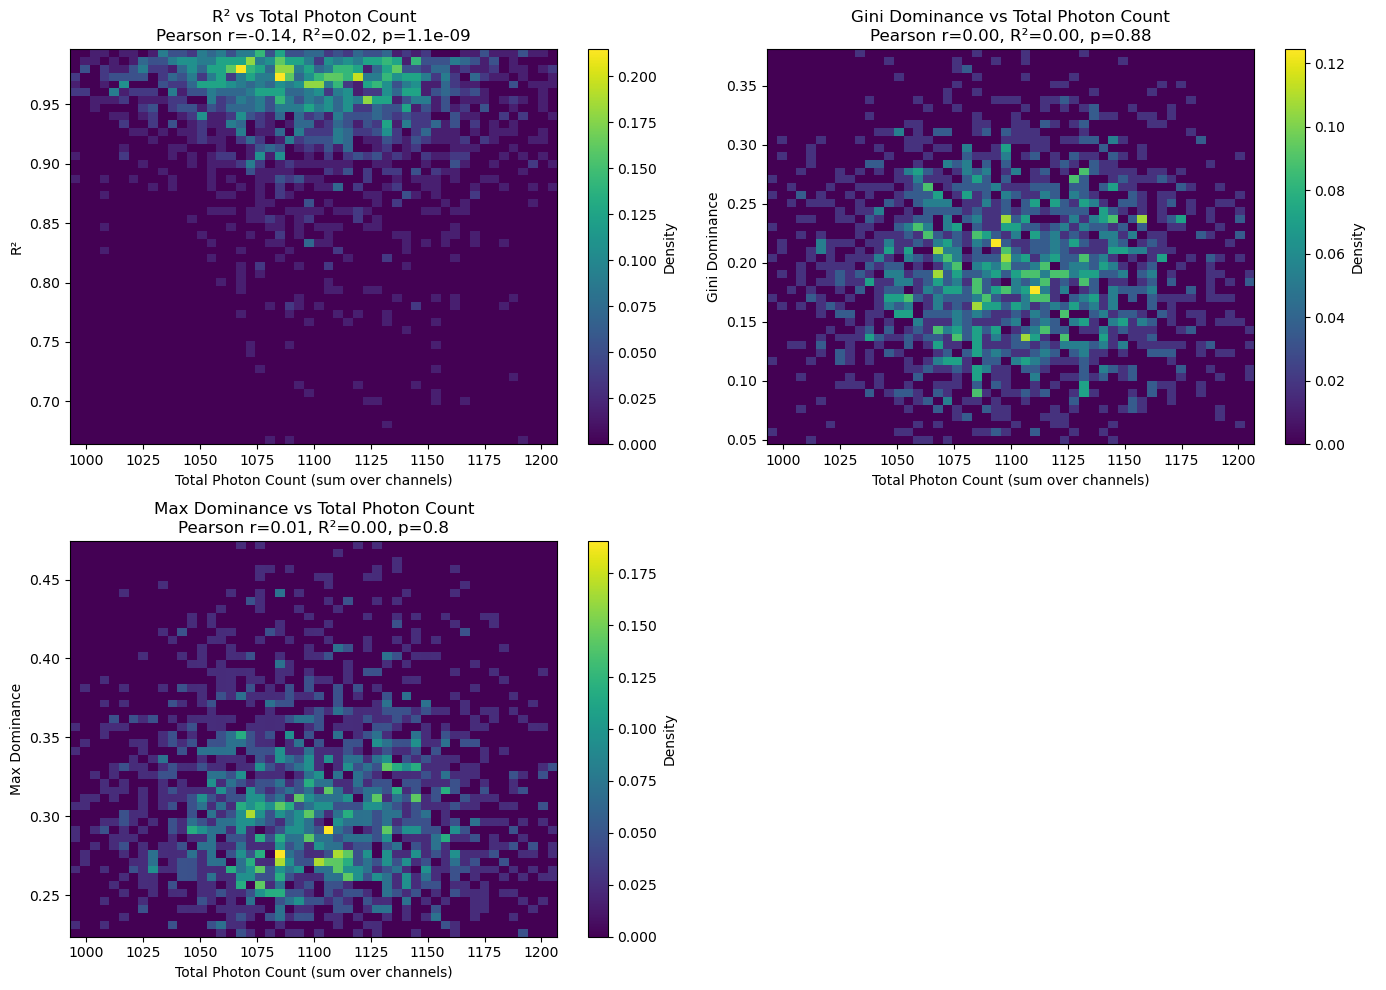

In [22]:
# Plot: Distribution of total photon counts from the simulator as a function of R², Gini dominance, and max dominance
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Get photon counts from simulator results (assume 'val_x' is the simulated measurement, shape: (n_val, n_channels))
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
if val_x is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    total_photons = np.sum(val_x_np, axis=1)
    r2_scores = np.array(trainer.results['r2_scores'])
    # Gini and max dominance (assume dye_fractions, gini_dominance, dominance already computed)
    # Compute 0.5th and 99.5th percentiles for all axes
    x_min, x_max = np.percentile(total_photons, [0.5, 99.5])
    y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
    y2_min, y2_max = np.percentile(gini_dominance, [0.5, 99.5])
    y3_min, y3_max = np.percentile(dominance, [0.5, 99.5])
    # Compute correlations
    corr_r2, pval_r2 = pearsonr(total_photons, r2_scores)
    r2_r2 = corr_r2 ** 2
    corr_gini, pval_gini = pearsonr(total_photons, gini_dominance)
    r2_gini = corr_gini ** 2
    corr_max, pval_max = pearsonr(total_photons, dominance)
    r2_max = corr_max ** 2
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    # Photon count vs R²
    h1 = axes[0,0].hist2d(total_photons, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
    plt.colorbar(h1[3], ax=axes[0,0], label='Density')
    axes[0,0].set_xlabel('Total Photon Count (sum over channels)')
    axes[0,0].set_ylabel('R²')
    axes[0,0].set_title(f'R² vs Total Photon Count\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
    axes[0,0].set_ylim(y1_min, y1_max)
    # Photon count vs Gini dominance
    h2 = axes[0,1].hist2d(total_photons, gini_dominance, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
    plt.colorbar(h2[3], ax=axes[0,1], label='Density')
    axes[0,1].set_xlabel('Total Photon Count (sum over channels)')
    axes[0,1].set_ylabel('Gini Dominance')
    axes[0,1].set_title(f'Gini Dominance vs Total Photon Count\nPearson r={corr_gini:.2f}, R²={r2_gini:.2f}, p={pval_gini:.2g}')
    axes[0,1].set_ylim(y2_min, y2_max)
    # Photon count vs max dominance
    h3 = axes[1,0].hist2d(total_photons, dominance, bins=[50, 50], range=[[x_min, x_max], [y3_min, y3_max]], cmap='viridis', density=True)
    plt.colorbar(h3[3], ax=axes[1,0], label='Density')
    axes[1,0].set_xlabel('Total Photon Count (sum over channels)')
    axes[1,0].set_ylabel('Max Dominance')
    axes[1,0].set_title(f'Max Dominance vs Total Photon Count\nPearson r={corr_max:.2f}, R²={r2_max:.2f}, p={pval_max:.2g}')
    axes[1,0].set_ylim(y3_min, y3_max)
    # Hide unused subplot
    axes[1,1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Photon count data (val_x) not found in trainer results.')

In [23]:
# Section 9: Save ExperimenZt Results
trainer.save()


Experiment results saved to sbi_training_demo_results/results.pt


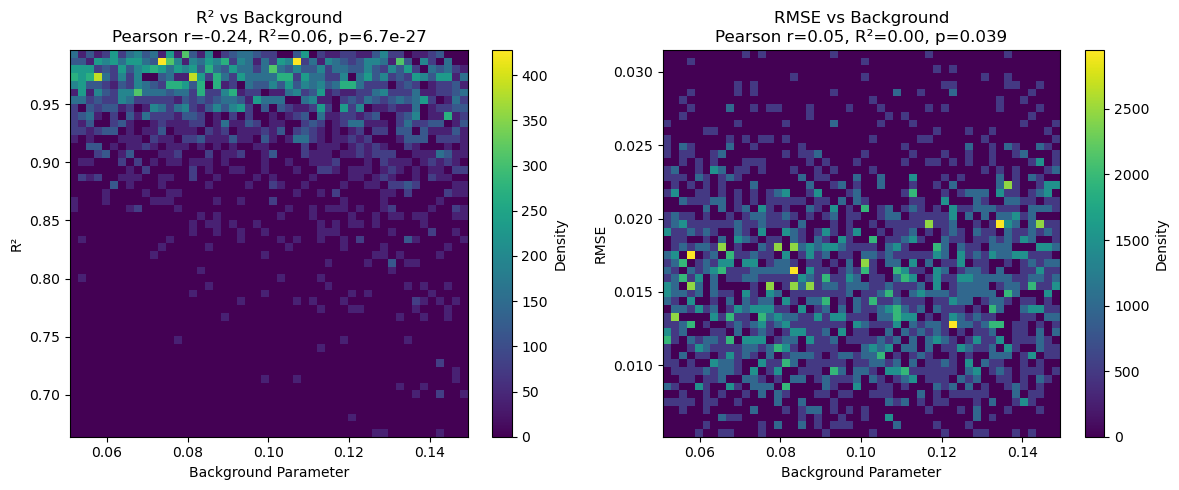

In [23]:
# Plot: R² and RMSE as a function of background parameter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Get background parameter (assume last column of val_theta if background is present)
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']
names = list(trainer.simulator.config.dye_names)
has_bg = hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye
if has_bg and val_theta.shape[1] > len(names):
    bg = val_theta[:, -1]
    r2_scores = np.array(trainer.results['r2_scores'])
    rmse_scores = np.array(trainer.results['rmse_scores'])
    # Compute 0.5th and 99.5th percentiles for all axes
    x_min, x_max = np.percentile(bg, [0.5, 99.5])
    y1_min, y1_max = np.percentile(r2_scores, [0.5, 99.5])
    y2_min, y2_max = np.percentile(rmse_scores, [0.5, 99.5])
    # Compute correlations
    corr_r2, pval_r2 = pearsonr(bg, r2_scores)
    r2_r2 = corr_r2 ** 2
    corr_rmse, pval_rmse = pearsonr(bg, rmse_scores)
    r2_rmse = corr_rmse ** 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Background vs R²
    h1 = axes[0].hist2d(bg, r2_scores, bins=[50, 50], range=[[x_min, x_max], [y1_min, y1_max]], cmap='viridis', density=True)
    plt.colorbar(h1[3], ax=axes[0], label='Density')
    axes[0].set_xlabel('Background Parameter')
    axes[0].set_ylabel('R²')
    axes[0].set_title(f'R² vs Background\nPearson r={corr_r2:.2f}, R²={r2_r2:.2f}, p={pval_r2:.2g}')
    axes[0].set_ylim(y1_min, y1_max)
    # Background vs RMSE
    h2 = axes[1].hist2d(bg, rmse_scores, bins=[50, 50], range=[[x_min, x_max], [y2_min, y2_max]], cmap='viridis', density=True)
    plt.colorbar(h2[3], ax=axes[1], label='Density')
    axes[1].set_xlabel('Background Parameter')
    axes[1].set_ylabel('RMSE')
    axes[1].set_title(f'RMSE vs Background\nPearson r={corr_rmse:.2f}, R²={r2_rmse:.2f}, p={pval_rmse:.2g}')
    axes[1].set_ylim(y2_min, y2_max)
    plt.tight_layout()
    plt.show()
else:
    print('No background parameter found in val_theta.')

## Advanced Posterior Analysis for Demultiplexing
This section explores advanced ways to analyze the posterior to find the best parameters for demultiplexing, including:
- Posterior width (uncertainty) vs. parameter space
- Mutual information between observations and parameters
- Posterior predictive checks
- Entropy maps
- Coverage probability
- Mode separation and multimodality
- Fisher information analysis
- Parameter correlation in the posterior
- Posterior volume (determinant of covariance)
- Active learning/experimental design

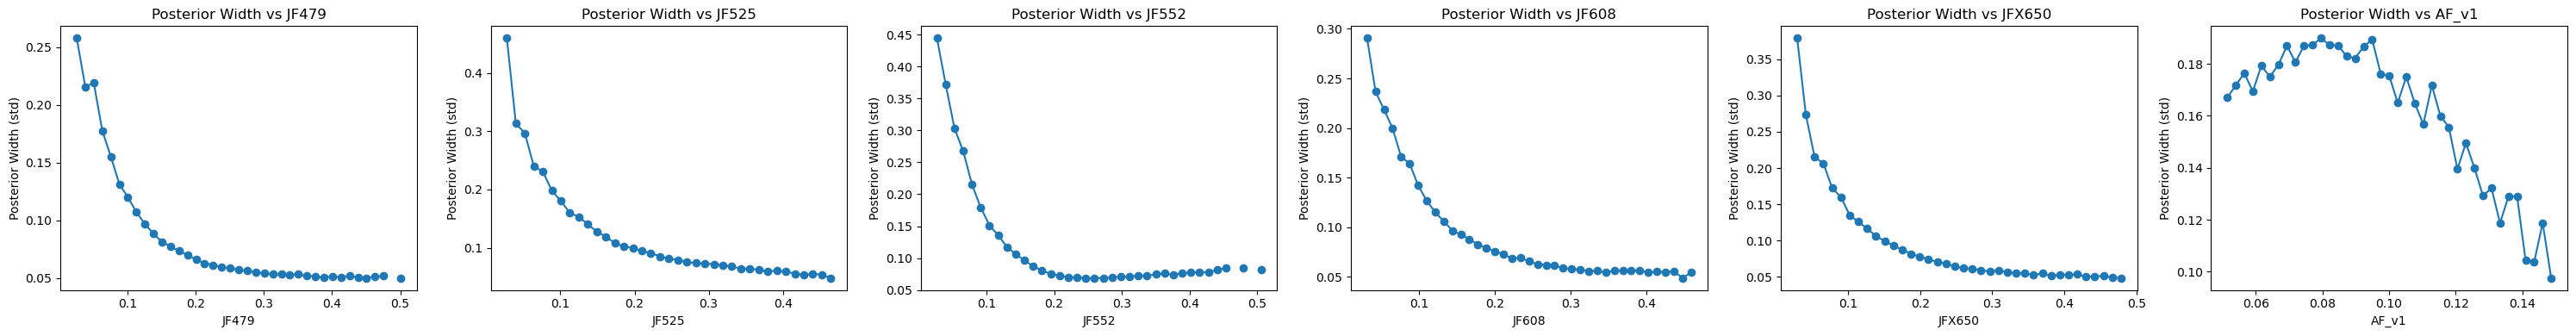

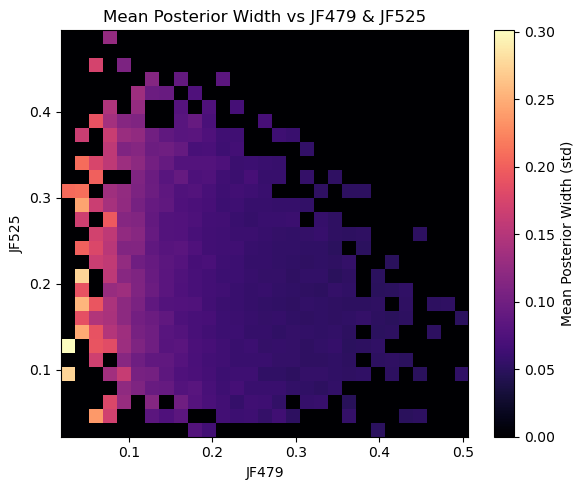

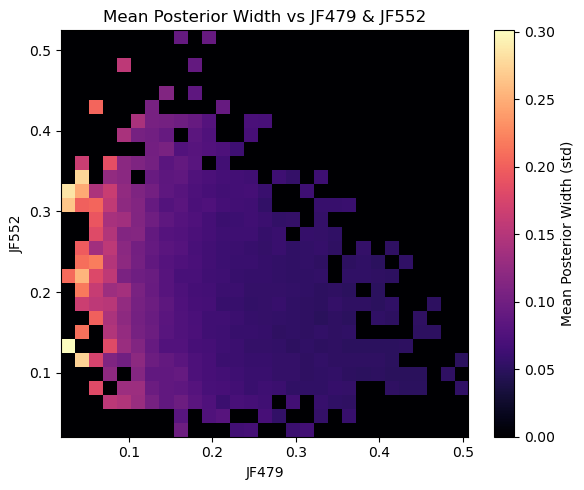

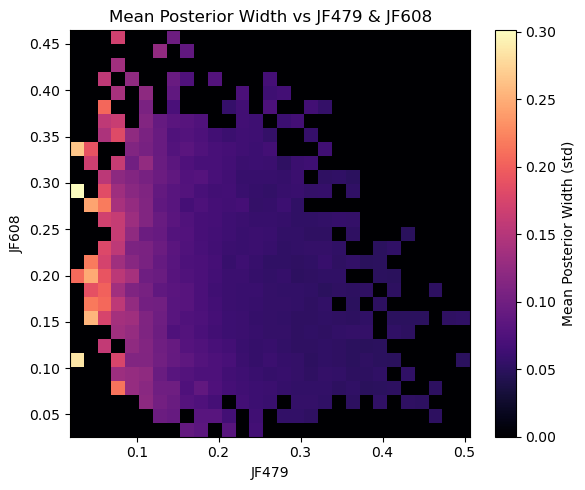

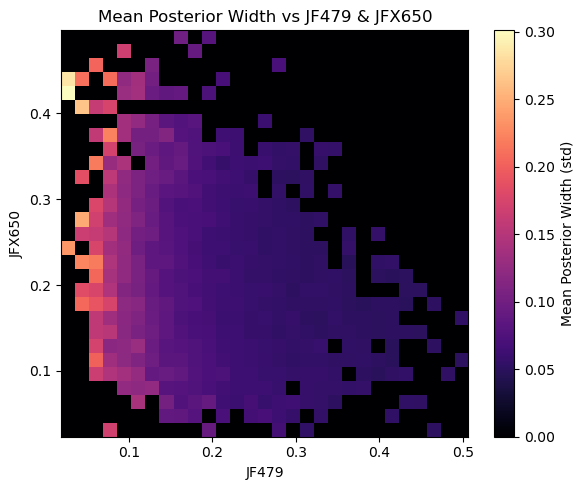

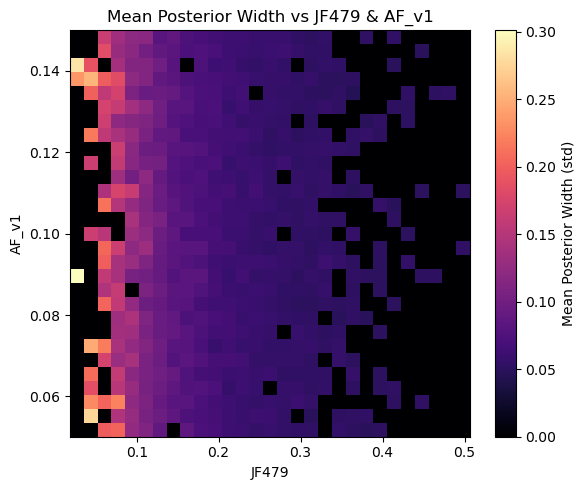

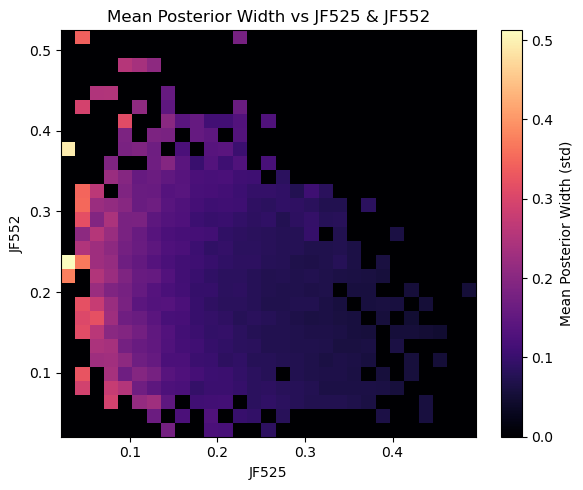

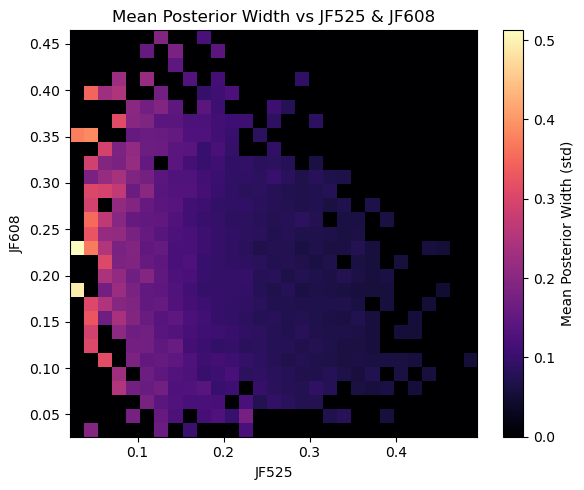

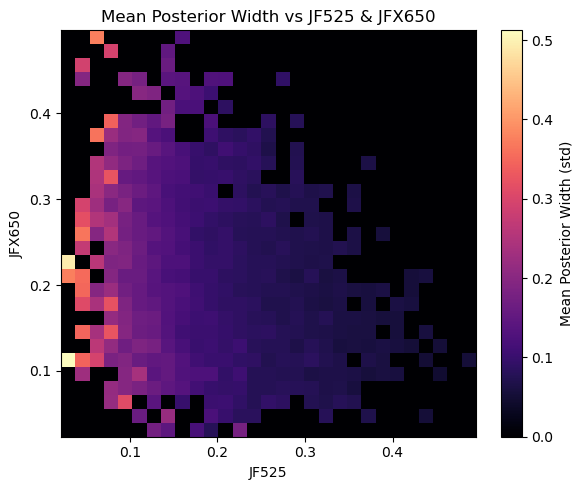

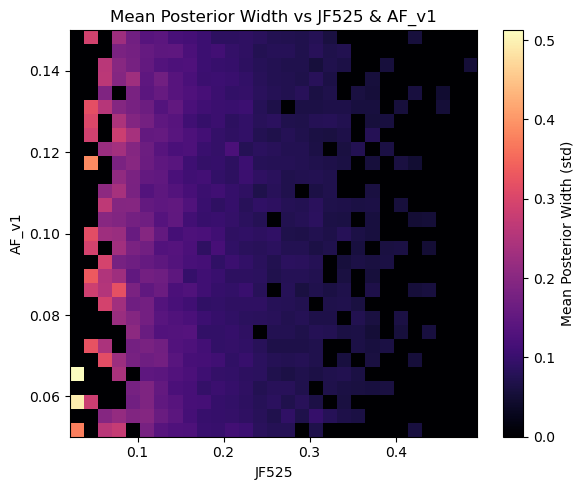

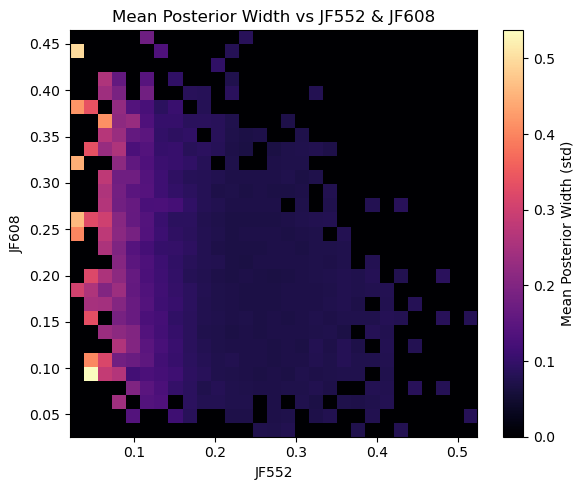

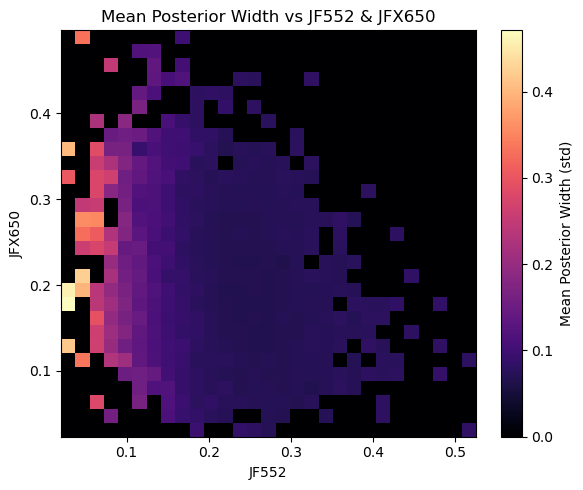

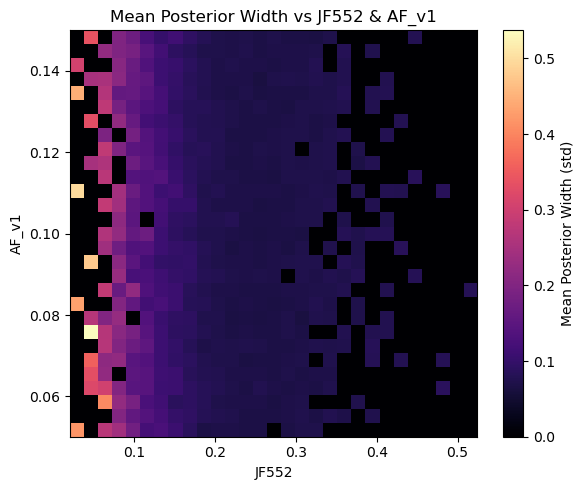

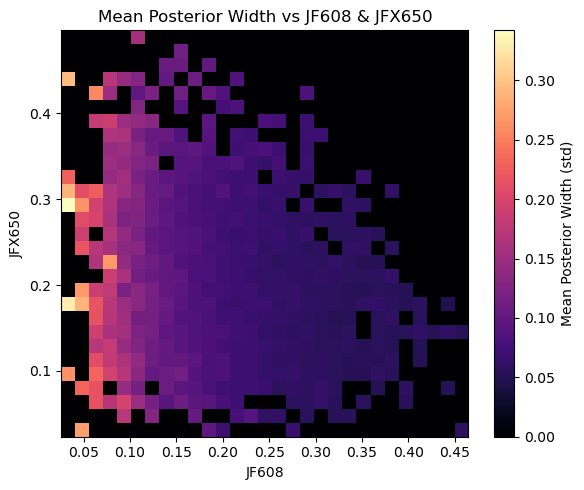

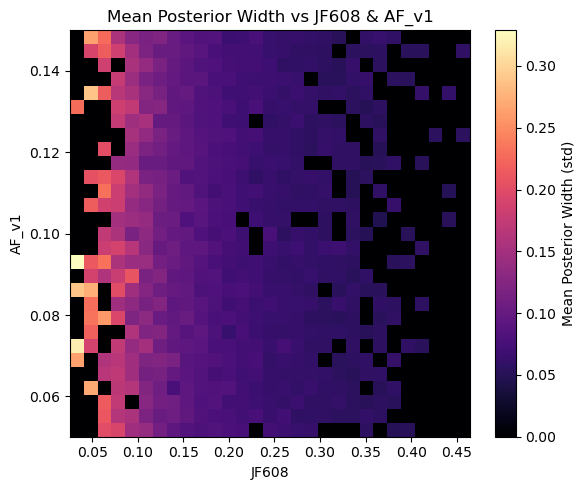

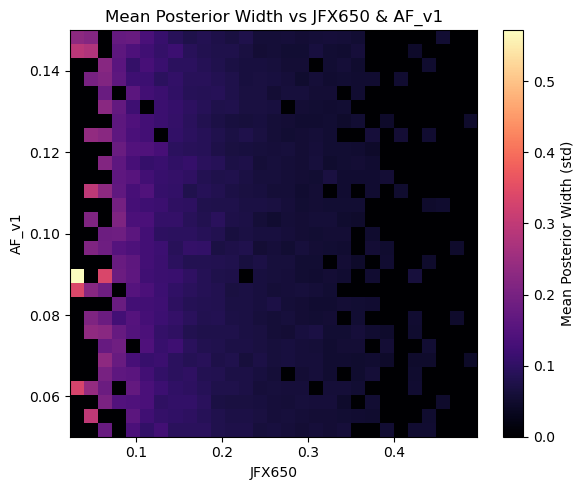

In [24]:
# 1. Posterior width (uncertainty) vs. parameter space
import numpy as np
import matplotlib.pyplot as plt

posterior_width = trainer.results['posterior_width']  # shape: (n_val, n_params)
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
n_params = posterior_width.shape[1]

# Plot posterior width vs each parameter
fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
if n_params == 1:
    axes = [axes]
for i in range(n_params):
    x = val_theta[:, i]
    y = posterior_width[:, i]
    # Bin x for smoother curves
    bins = np.linspace(x.min(), x.max(), 40)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    inds = np.digitize(x, bins) - 1
    mean_width = [np.mean(y[inds == j]) if np.any(inds == j) else np.nan for j in range(len(bin_centers))]
    axes[i].plot(bin_centers, mean_width, marker='o')
    axes[i].set_xlabel(f'{names[i]}')
    axes[i].set_ylabel('Posterior Width (std)')
    axes[i].set_title(f'Posterior Width vs {names[i]}')
plt.tight_layout()
plt.show()

# Pairwise heatmaps: mean posterior width as a function of parameter pairs
if n_params > 1:
    from itertools import combinations
    combs = list(combinations(range(n_params), 2))
    for i, j in combs:
        xi, xj = val_theta[:, i], val_theta[:, j]
        width_ij = posterior_width[:, i]
        bins_i = np.linspace(xi.min(), xi.max(), 30)
        bins_j = np.linspace(xj.min(), xj.max(), 30)
        H, xedges, yedges = np.histogram2d(xi, xj, bins=[bins_i, bins_j], weights=width_ij)
        counts, _, _ = np.histogram2d(xi, xj, bins=[bins_i, bins_j])
        mean_width_2d = np.divide(H, counts, out=np.zeros_like(H), where=counts>0)
        plt.figure(figsize=(6,5))
        plt.imshow(mean_width_2d.T, origin='lower', aspect='auto', extent=[bins_i[0], bins_i[-1], bins_j[0], bins_j[-1]], cmap='magma')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.title(f'Mean Posterior Width vs {names[i]} & {names[j]}')
        plt.colorbar(label='Mean Posterior Width (std)')
        plt.tight_layout()
        plt.show()

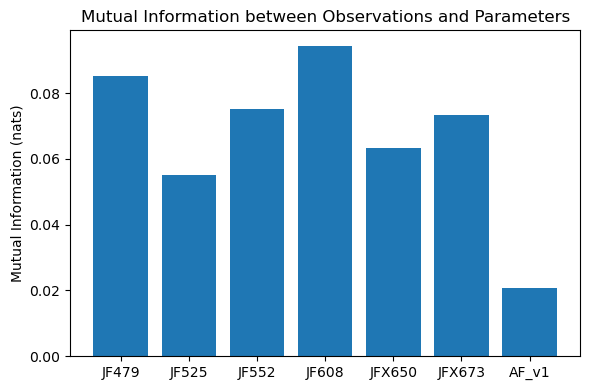

In [26]:
# 2. Mutual information between observations and parameters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Use validation data: val_x (observations), val_theta (parameters)
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_params = val_theta.shape[1]
    mi = []
    for i in range(n_params):
        # Mutual information between each parameter and the full observation vector
        mi_i = mutual_info_regression(val_x_np, val_theta[:, i], random_state=0)
        mi.append(np.mean(mi_i))  # Average MI across all channels
    names = list(trainer.simulator.config.dye_names)
    if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
        names = names + [trainer.simulator.config.bg_dye]
    if len(names) < n_params:
        names += [f'Param {i+1}' for i in range(len(names), n_params)]
    plt.figure(figsize=(6, 4))
    plt.bar(names, mi)
    plt.ylabel('Mutual Information (nats)')
    plt.title('Mutual Information between Observations and Parameters')
    plt.tight_layout()
    plt.show()
else:
    print('Observation data (val_x) not found in trainer results.')

Drawing 1000 posterior samples: 1094it [00:00, 2568.26it/s]                         
/tmp/ipykernel_1372494/2816025158.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(samples, labels=names, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]
/tmp/ipykernel_1372494/2816025158.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(samples, labels=names, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
Drawing 1000 posterior samples: 1090it [00:00, 2656.73it/s]                         
/tmp/ipykernel_1372494/2816025158.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been r

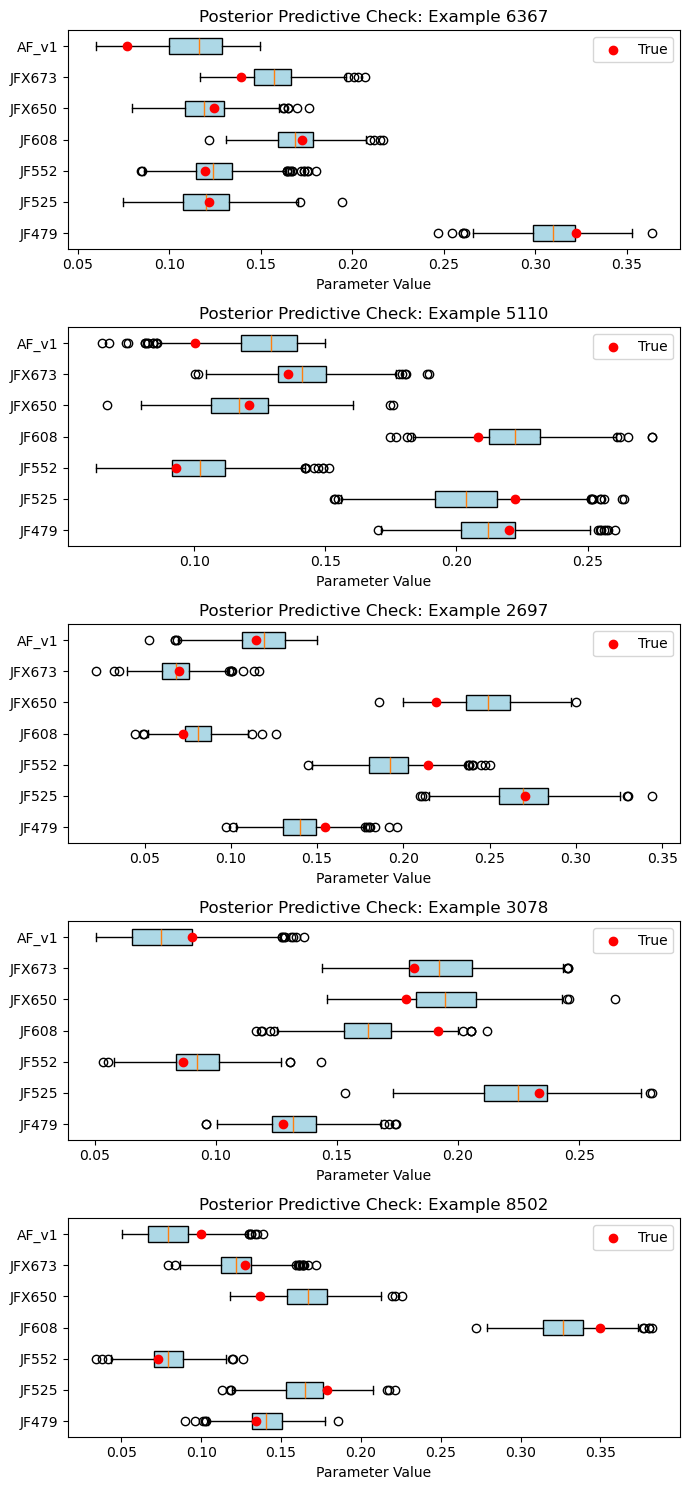

In [27]:
# 3. Posterior Predictive Checks
import numpy as np
import matplotlib.pyplot as plt

# Draw samples from the posterior for a random subset of validation observations
n_examples = 5  # Number of examples to visualize
n_samples = 1000  # Number of posterior samples per example
rng = np.random.default_rng(0)

val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    idxs = rng.choice(len(val_x_np), size=n_examples, replace=False)
    fig, axes = plt.subplots(n_examples, 1, figsize=(7, 3 * n_examples))
    if n_examples == 1:
        axes = [axes]
    for i, idx in enumerate(idxs):
        obs = val_x_np[idx:idx+1]
        # Draw posterior samples for this observation
        samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32))
        samples = samples.detach().cpu().numpy()
        # Plot true parameter vs posterior samples for each parameter
        n_params = samples.shape[1]
        names = list(trainer.simulator.config.dye_names)
        if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
            names = names + [trainer.simulator.config.bg_dye]
        if len(names) < n_params:
            names += [f'Param {j+1}' for j in range(len(names), n_params)]
        axes[i].boxplot(samples, labels=names, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        axes[i].scatter(val_theta[idx], np.arange(1, n_params+1), color='red', label='True', zorder=3)
        axes[i].set_title(f'Posterior Predictive Check: Example {idx}')
        axes[i].set_xlabel('Parameter Value')
        axes[i].legend()
    plt.tight_layout()
    plt.show()
else:
    print('Posterior or validation data not found for predictive checks.')

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

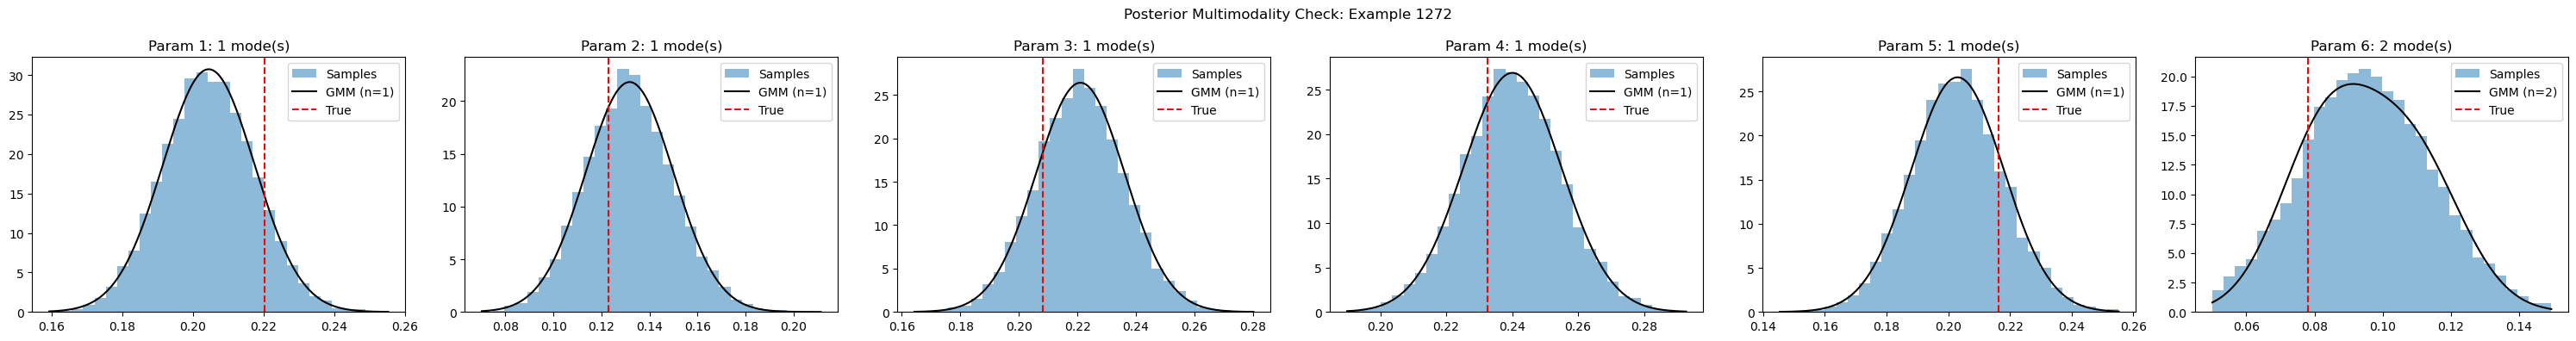

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

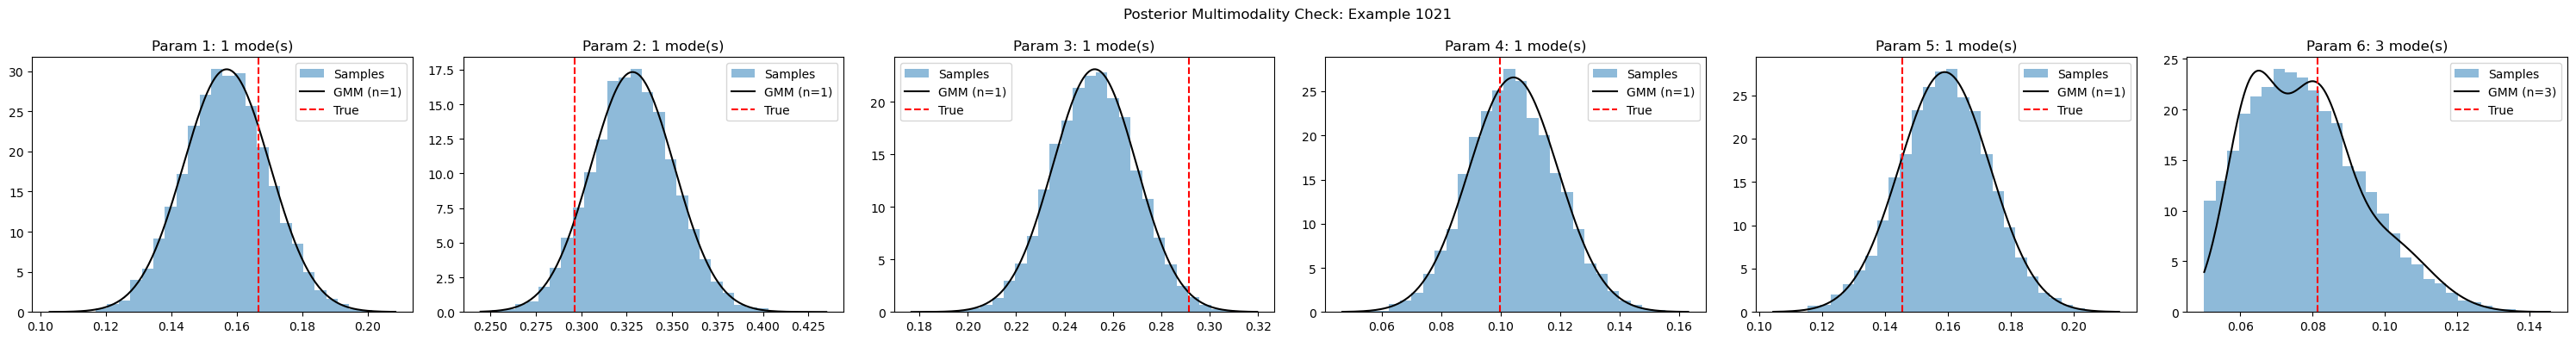

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

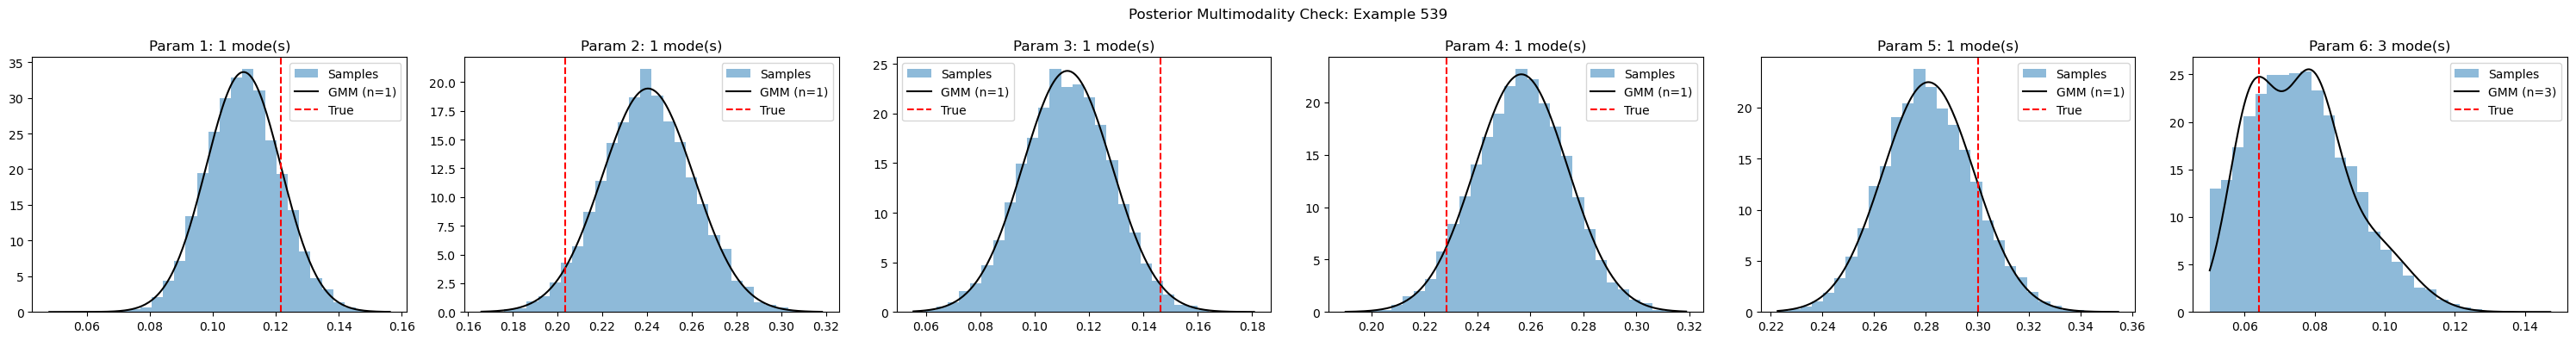

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

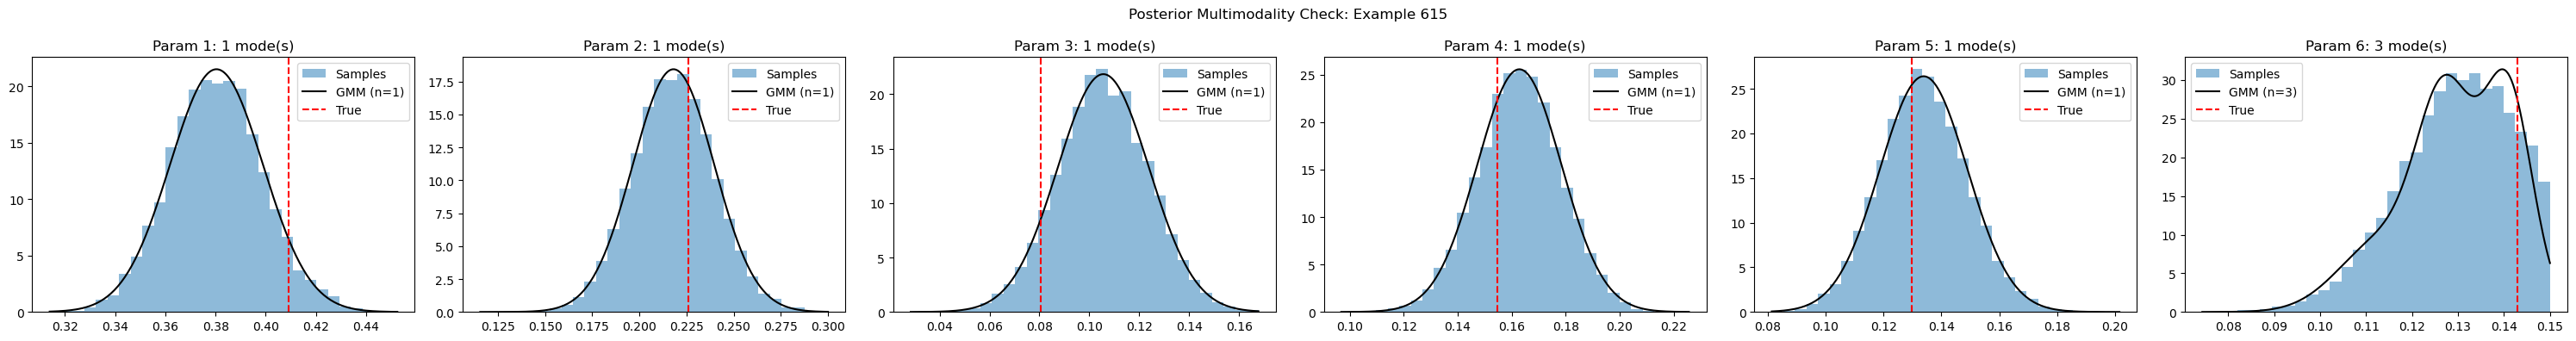

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

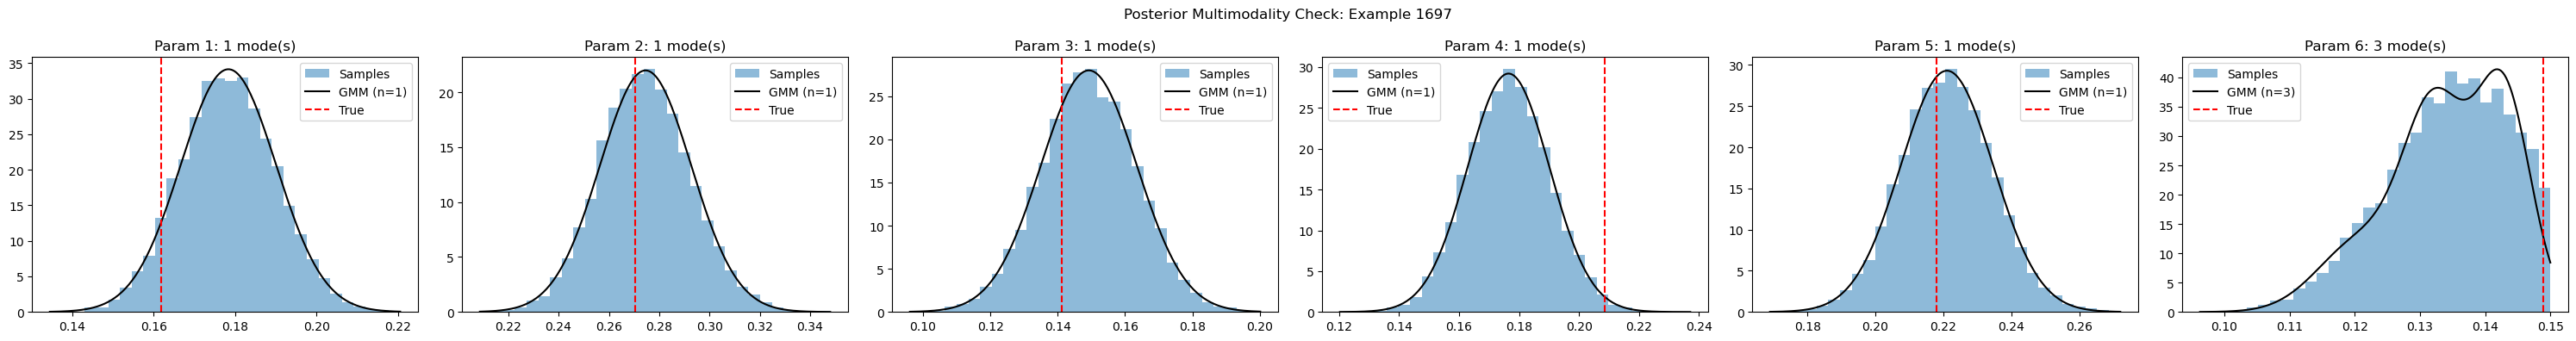

In [25]:
# 6. Mode Separation and Multimodality: Detect and visualize multimodal posteriors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

n_samples = 10000
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
val_theta = trainer.results['val_theta'].numpy() if hasattr(trainer.results['val_theta'], 'numpy') else trainer.results['val_theta']

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_val, n_params = val_theta.shape
    n_examples = 5  # Number of validation examples to check
    rng = np.random.default_rng(0)
    idxs = rng.choice(n_val, size=n_examples, replace=False)
    for idx in idxs:
        obs = val_x_np[idx:idx+1]
        samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32))
        samples = samples.detach().cpu().numpy()
        # Fit a Gaussian Mixture Model to the samples for each parameter
        fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
        if n_params == 1:
            axes = [axes]
        for j in range(n_params):
            param_samples = samples[:, j].reshape(-1, 1)
            bic = []
            for n_components in range(1, 4):
                gmm = GaussianMixture(n_components=n_components, random_state=0)
                gmm.fit(param_samples)
                bic.append(gmm.bic(param_samples))
            best_n = np.argmin(bic) + 1
            best_gmm = GaussianMixture(n_components=best_n, random_state=0).fit(param_samples)
            x_grid = np.linspace(param_samples.min(), param_samples.max(), 200).reshape(-1, 1)
            logprob = best_gmm.score_samples(x_grid)
            axes[j].hist(param_samples, bins=30, density=True, alpha=0.5, label='Samples')
            axes[j].plot(x_grid, np.exp(logprob), 'k-', label=f'GMM (n={best_n})')
            axes[j].axvline(val_theta[idx, j], color='red', linestyle='--', label='True')
            axes[j].set_title(f'Param {j+1}: {best_n} mode(s)')
            axes[j].legend()
        plt.suptitle(f'Posterior Multimodality Check: Example {idx}')
        plt.tight_layout()
        plt.show()
else:
    print('Posterior or validation data not found for multimodality analysis.')

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

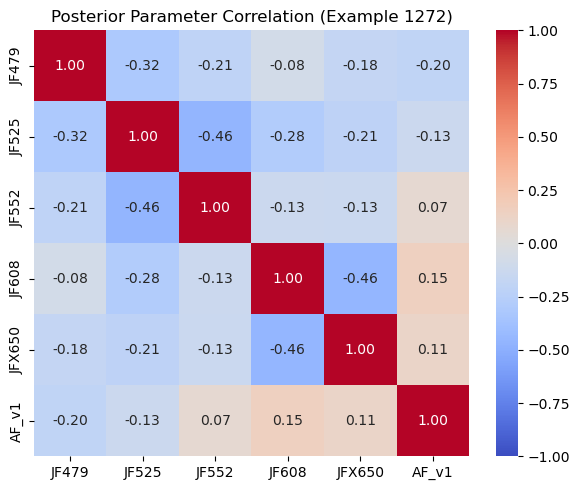

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

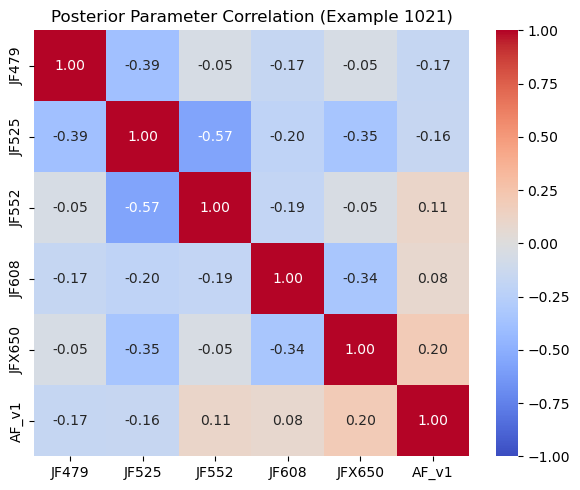

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

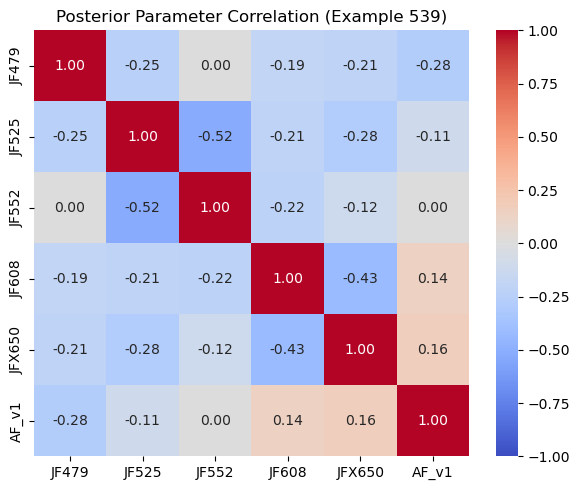

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

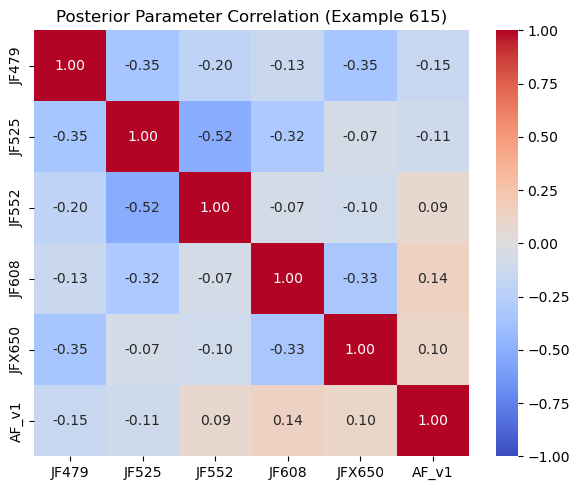

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

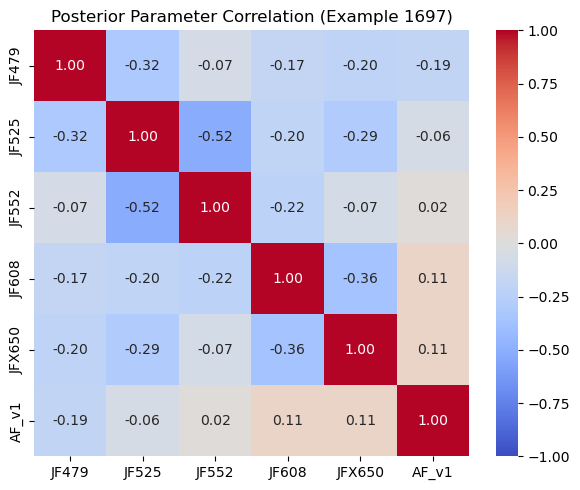

In [26]:
# 7. Parameter Correlation in the Posterior: Visualize pairwise correlations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = 100000
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None

if val_x is not None and hasattr(trainer, 'posterior') and trainer.posterior is not None:
    # Convert to numpy if it's a torch tensor
    if hasattr(val_x, 'numpy'):
        val_x_np = val_x.numpy()
    else:
        val_x_np = np.array(val_x)
    n_val = val_x_np.shape[0]
    n_examples = 5  # Number of validation examples to visualize
    rng = np.random.default_rng(0)
    idxs = rng.choice(n_val, size=n_examples, replace=False)
    for idx in idxs:
        obs = val_x_np[idx:idx+1]
        samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32))
        samples = samples.detach().cpu().numpy()
        corr = np.corrcoef(samples, rowvar=False)
        names = list(trainer.simulator.config.dye_names)
        if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
            names = names + [trainer.simulator.config.bg_dye]
        if len(names) < samples.shape[1]:
            names += [f'Param {k+1}' for k in range(len(names), samples.shape[1])]
        plt.figure(figsize=(6, 5))
        sns.heatmap(corr, annot=True, fmt=".2f", xticklabels=names, yticklabels=names, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Posterior Parameter Correlation (Example {idx})')
        plt.tight_layout()
        plt.show()
else:
    print('Posterior or validation data not found for correlation analysis.')

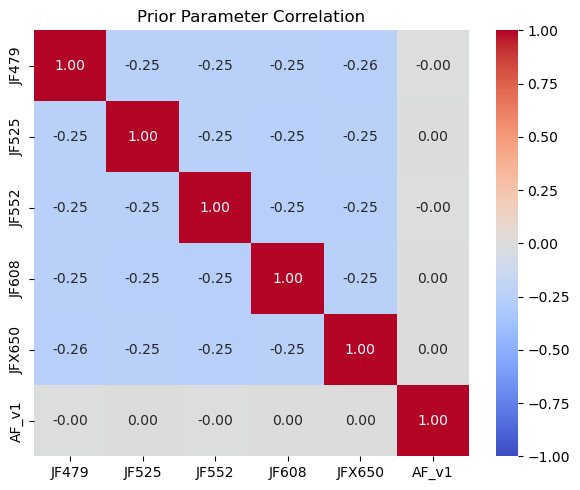

In [27]:
# Sample from the prior and compute parameter correlations
n_prior = 100000
prior_samples = trainer.prior.sample((n_prior,))
if hasattr(prior_samples, 'numpy'):
    prior_samples = prior_samples.numpy()
prior_corr = np.corrcoef(prior_samples, rowvar=False)
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
if len(names) < prior_samples.shape[1]:
    names += [f'Param {k+1}' for k in range(len(names), prior_samples.shape[1])]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
sns.heatmap(prior_corr, annot=True, fmt=".2f", xticklabels=names, yticklabels=names, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Prior Parameter Correlation')
plt.tight_layout()
plt.show()

Processing validation example 1/100...
Processing validation example 2/100...
Processing validation example 3/100...
Processing validation example 4/100...
Processing validation example 5/100...
Processing validation example 6/100...
Processing validation example 7/100...
Processing validation example 8/100...
Processing validation example 9/100...
Processing validation example 10/100...
Processing validation example 11/100...
Processing validation example 12/100...
Processing validation example 13/100...
Processing validation example 14/100...
Processing validation example 15/100...
Processing validation example 16/100...
Processing validation example 17/100...
Processing validation example 18/100...
Processing validation example 19/100...
Processing validation example 20/100...
Processing validation example 21/100...
Processing validation example 22/100...
Processing validation example 23/100...
Processing validation example 24/100...
Processing validation example 25/100...
Processin

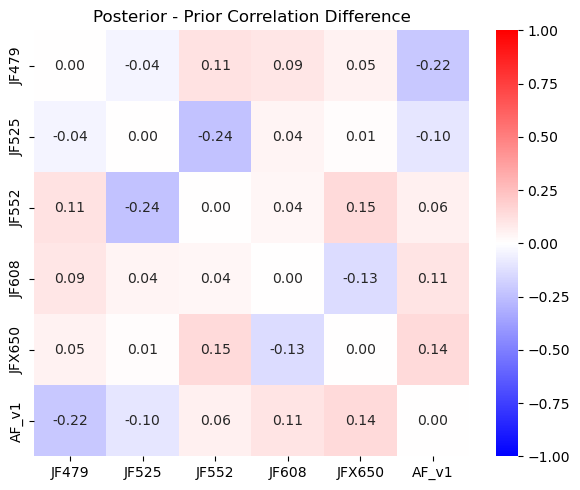

In [28]:
# Compare posterior and prior parameter correlations and visualize the difference


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Prior correlation ---
n_prior = 10000
prior_samples = trainer.prior.sample((n_prior,))
if hasattr(prior_samples, 'numpy'):
    prior_samples = prior_samples.numpy()
prior_corr = np.corrcoef(prior_samples, rowvar=False)

# --- Posterior correlation (average over a few random validation examples) ---
n_samples = 10000
val_x = trainer.results['val_x'] if hasattr(trainer.results['val_x'], 'shape') else None
if hasattr(val_x, 'numpy'):
    val_x_np = val_x.numpy()
else:
    val_x_np = np.array(val_x)
n_val = val_x_np.shape[0]
n_examples = 100
rng = np.random.default_rng(0)
idxs = rng.choice(n_val, size=n_examples, replace=False)
posterior_corrs = []
for i, idx in enumerate(idxs):
    print(f"Processing validation example {i+1}/{n_examples}...")
    obs = val_x_np[idx:idx+1]
    samples = trainer.posterior.sample((n_samples,), x=torch.tensor(obs, dtype=torch.float32), show_progress_bars=False)
    samples = samples.detach().cpu().numpy()
    posterior_corrs.append(np.corrcoef(samples, rowvar=False))
posterior_corr = np.mean(posterior_corrs, axis=0)

# --- Difference heatmap ---
names = list(trainer.simulator.config.dye_names)
if hasattr(trainer.simulator.config, 'bg_dye') and trainer.simulator.config.bg_dye:
    names = names + [trainer.simulator.config.bg_dye]
if len(names) < prior_samples.shape[1]:
    names += [f'Param {k+1}' for k in range(len(names), prior_samples.shape[1])]

plt.figure(figsize=(6, 5))
sns.heatmap(posterior_corr - prior_corr, annot=True, fmt=".2f", xticklabels=names, yticklabels=names, center=0, cmap='bwr', vmin=-1, vmax=1)
plt.title('Posterior - Prior Correlation Difference')
plt.tight_layout()
plt.show()

In [ ]:
# Save trainer and simulator to disk
import pickle

with open('trainer_and_simulator.pkl', 'wb') as f:
    pickle.dump({'trainer': trainer, 'simulator': trainer.simulator}, f)
print("Trainer and simulator saved to trainer_and_simulator.pkl")

In [ ]:
# Load trainer and simulator from disk
import pickle

with open('trainer_and_simulator.pkl', 'rb') as f:
    data = pickle.load(f)
loaded_trainer = data['trainer']
loaded_simulator = data['simulator']
print("Trainer and simulator loaded from trainer_and_simulator.pkl")